# Part I. Data Extraction

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, RFE, SequentialFeatureSelector, SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall
from sklearn.inspection import permutation_importance
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [4]:
master_data = pd.read_csv("C:/Users/Admin/Downloads/diabetes.csv")

In [5]:
pd.set_option('display.max_columns', None)

# Part II. Exploratory Data Analysis

In [6]:
master_data.head()

,Age,Gender,BMI,SBP,DBP,FPG,Chol,Tri,HDL,LDL,ALT,BUN,CCR,FFPG,smoking,drinking,family_histroy,Diabetes
0,26,1,20.1,119,81,5.80,4.36,0.86,0.90,2.43,12.0,5.40,63.8,5.40,3.0,3.0,0,0
1,40,1,17.7,97,54,4.60,3.70,1.02,1.50,2.04,9.2,3.70,70.3,4.10,1.0,1.0,0,0
2,40,2,19.7,85,53,5.30,5.87,1.29,1.75,3.37,10.1,4.10,61.1,4.85,3.0,3.0,0,0
3,43,1,23.1,111,71,4.50,4.05,0.74,1.27,2.60,36.5,4.38,73.4,5.30,2.0,3.0,0,0
4,36,1,26.5,130,82,5.54,6.69,3.49,0.91,3.64,69.3,3.86,67.5,5.53,3.0,3.0,0,0


In [7]:
master_data.shape

(4299, 18)

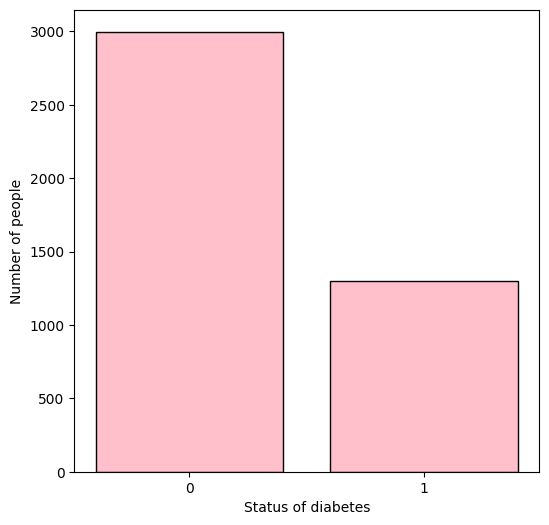

In [9]:
# Count number of people for each diabetes status
counts = master_data['Diabetes'].value_counts().sort_index()  # Ensures order: 0, 1

# Plot
plt.figure(figsize=(6, 6))
plt.bar(counts.index.astype(str), counts.values, color='pink', edgecolor='black')

plt.xlabel("Status of diabetes")
plt.ylabel("Number of people")
plt.title("")

plt.show()

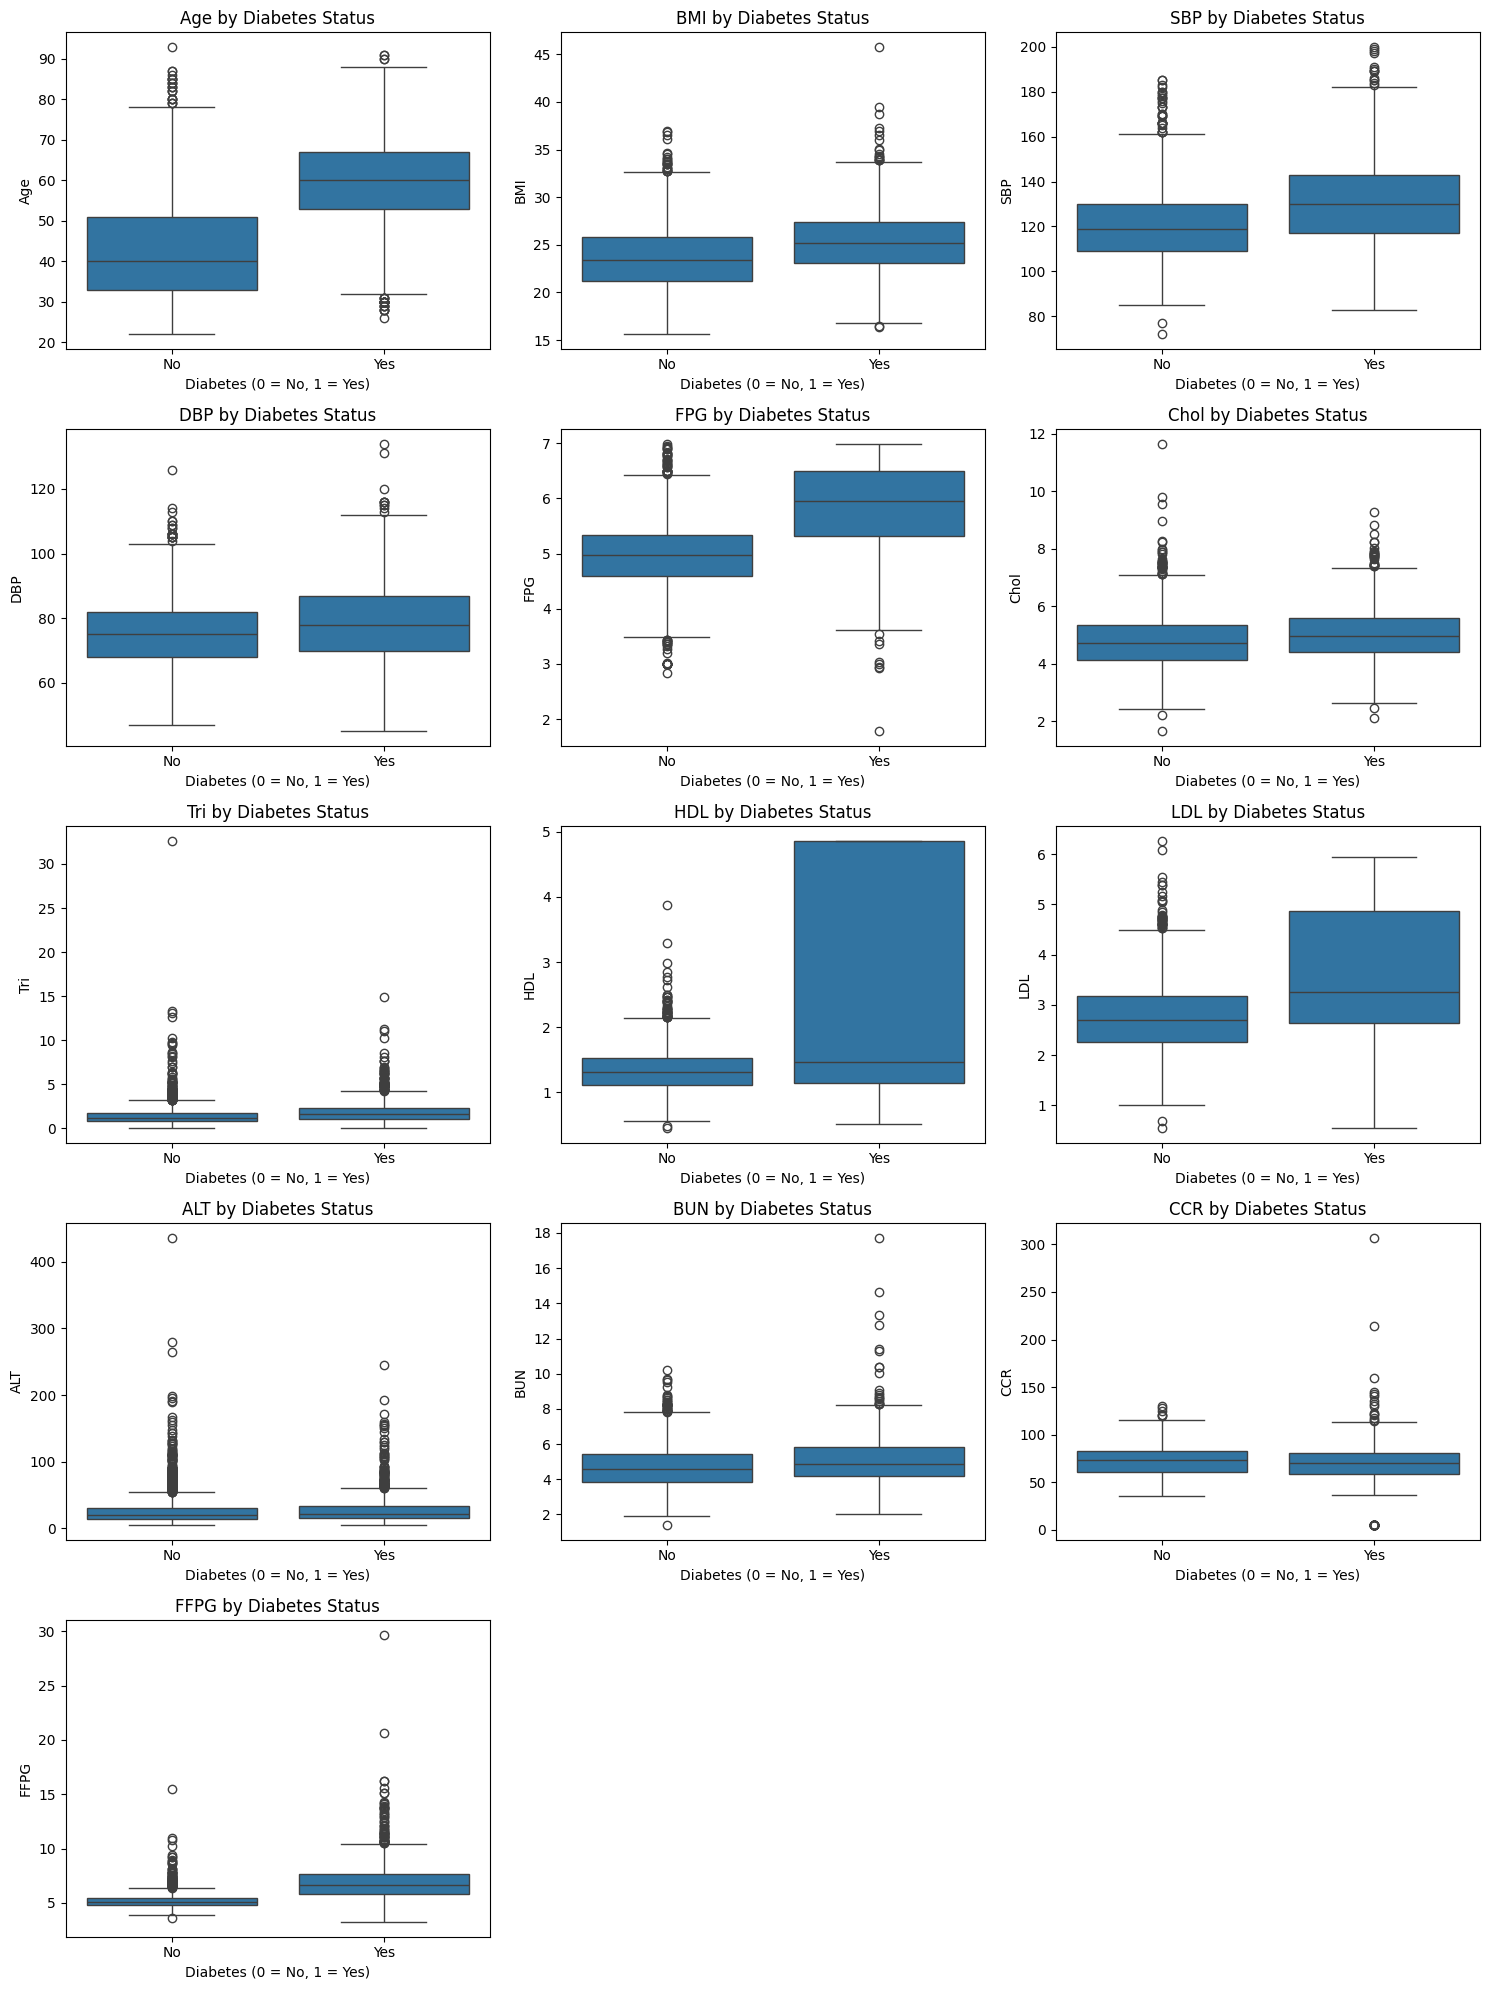

In [7]:
variables = ['Age', 'BMI', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL', 'LDL', 'ALT', 'BUN', 'CCR', 'FFPG']

# Set up the plotting area
n_cols = 3
n_rows = -(-len(variables) // n_cols)  # Ceiling division

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, var in enumerate(variables, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x='Diabetes', y=var, data=master_data)
    plt.title(f'{var} by Diabetes Status')
    plt.xlabel('Diabetes (0 = No, 1 = Yes)')
    plt.ylabel(var)
    plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout()
plt.show()

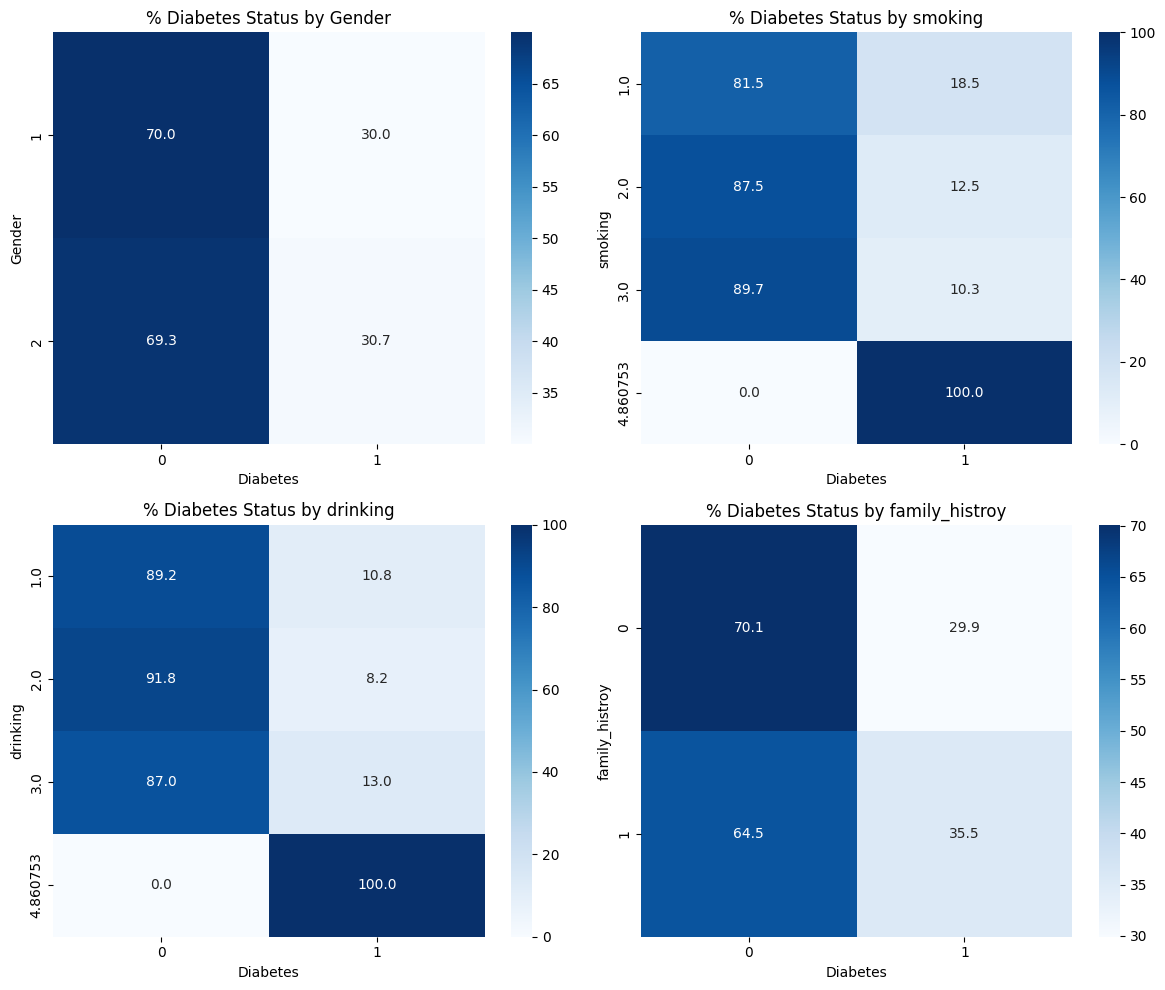

In [11]:
# Make sure to match the actual diabetes column name
diabetes_col = 'Diabetes'  # adjust if needed
predictors = ['Gender', 'smoking', 'drinking', 'family_histroy']

n_cols = 2
n_rows = -(-len(predictors) // n_cols)

plt.figure(figsize=(n_cols * 6, n_rows * 5))

for i, predictor in enumerate(predictors, 1):
    if predictor in master_data.columns:
        # Normalize by row: % of diabetes statuses within each predictor group
        crosstab = pd.crosstab(master_data[predictor], master_data[diabetes_col], normalize='index') * 100
        
        plt.subplot(n_rows, n_cols, i)
        sns.heatmap(crosstab, annot=True, fmt=".1f", cmap="Blues")
        plt.title(f'% Diabetes Status by {predictor}')
        plt.xlabel('Diabetes')
        plt.ylabel(predictor)

plt.tight_layout()
plt.show()

# Part III. Data Preprocessing

## Data Cleaning (Master Data)

In [6]:
master_data = master_data.replace(4.860753, np.nan)

In [7]:
# Rename column
master_data = master_data.rename(columns={'family_histroy': 'family_history'})

In [8]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             4299 non-null   int64  
 1   Gender          4299 non-null   int64  
 2   BMI             4299 non-null   float64
 3   SBP             4299 non-null   int64  
 4   DBP             4299 non-null   int64  
 5   FPG             4299 non-null   float64
 6   Chol            4285 non-null   float64
 7   Tri             4285 non-null   float64
 8   HDL             3888 non-null   float64
 9   LDL             3905 non-null   float64
 10  ALT             4290 non-null   float64
 11  BUN             4203 non-null   float64
 12  CCR             4265 non-null   float64
 13  FFPG            4299 non-null   float64
 14  smoking         3413 non-null   float64
 15  drinking        3413 non-null   float64
 16  family_history  4299 non-null   int64  
 17  Diabetes        4299 non-null   i

The dataset has 4303 data points and 18 features

### Handle missing values for categorical features

In [9]:
# Handle missing values for smoking, drinking
master_data['smoking'].fillna(master_data['smoking'].mode()[0], inplace=True)
master_data['drinking'].fillna(master_data['drinking'].mode()[0], inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_19568\3986873101.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  master_data['smoking'].fillna(master_data['smoking'].mode()[0], inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_19568\3986873101.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

In [10]:
master_data['smoking'] = master_data['smoking'].astype(int)
master_data['drinking'] = master_data['drinking'].astype(int)

### Handle misssing values for numeric features

In [11]:
# Handle missing values for Chol, Tri, ALT, BUN, CCR (less than 5% missing)
for col in ['Chol', 'Tri', 'ALT', 'BUN', 'CCR']:
    master_data[col].fillna(master_data[col].median(), inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_19568\841667338.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  master_data[col].fillna(master_data[col].median(), inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_19568\841667338.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [12]:
# Handle missing values for HDL, LDL (more than 10% missing)
# Use IterativeImputer

features_for_imputation = [
    'HDL', 'LDL', 'Chol', 'Tri', 'FPG', 'FFPG',
    'ALT', 'BUN', 'CCR', 'Age', 'Gender', 'BMI', 'SBP', 'DBP',
    'smoking', 'drinking', 'family_history'
]

# One-hot encode nominal categorical features
impute_df = master_data[features_for_imputation].copy()
impute_df = pd.get_dummies(impute_df, columns=['Gender', 'smoking', 'drinking'], drop_first=True)

# Impute
imputer = IterativeImputer(random_state=42)
imputed_data = imputer.fit_transform(impute_df)

# Assign back HDL and LDL
master_data['HDL'] = imputed_data[:, impute_df.columns.get_loc('HDL')]
master_data['LDL'] = imputed_data[:, impute_df.columns.get_loc('LDL')]

## Feature Engineering (Master Data)

In [13]:
master_data["MAP"] = (2*master_data["DBP"] + master_data["SBP"]) / 3

In [14]:
master_data['Glucose_Change'] = master_data['FFPG'] - master_data['FPG']

In [15]:
master_data['Chol_HDL_Ratio'] = master_data['Chol'] / master_data['HDL']

In [16]:
master_data['LDL_HDL_Ratio'] = master_data['LDL'] / master_data['HDL']

In [17]:
master_data['BUN_CCR_Ratio'] = master_data['BUN'] / master_data['CCR']

In [18]:
master_data['BMI_Age'] = master_data['BMI'] * master_data['Age']

In [19]:
master_data['FPG_BMI'] = master_data['FPG'] * master_data['BMI']

In [20]:
master_data['Tri_HDL_Ratio'] = master_data['Tri'] / master_data['HDL']

In [21]:
master_data['ALT_per_BMI'] = master_data['ALT'] / master_data['BMI']

In [22]:
master_data["Non_HDL"] = master_data["Chol"] - master_data["HDL"]

In [23]:
master_data["Pulse_Pressure"] = master_data["SBP"] - master_data["DBP"]

In [24]:
master_data["Obesity_Class"] = pd.cut(master_data["BMI"], [0,25,30,35,40,np.inf], labels=[0,1,2,3,4])

In [25]:
master_data["TG_HDL_Obesity"] = master_data["Tri_HDL_Ratio"] * master_data["BMI"]

In [26]:
master_data["ALT_to_CCR"] = master_data["ALT"] / master_data["CCR"]

In [27]:
master_data["Impaired_FPG_Flag"] = (master_data["FPG"] >= 5.6) & (master_data["FPG"] < 7)

## Split Data (Master Data)

In [28]:
X = master_data.drop('Diabetes', axis=1)
y = master_data['Diabetes']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,       # ensures class balance in train/test
    random_state=42
)

## Handle Class Imbalance (Training Data)

In [29]:
# Check counts and percentage of each class
class_counts = master_data['Diabetes'].value_counts()
class_percent = master_data['Diabetes'].value_counts(normalize=True) * 100

print("Class Counts:")
print(class_counts)

print("\nClass Percentages:")
print(class_percent)

Class Counts:
Diabetes
0    2998
1    1301
Name: count, dtype: int64

Class Percentages:
Diabetes
0    69.737148
1    30.262852
Name: proportion, dtype: float64


In [30]:
# Check class distribution
class_counts = y_train.value_counts()
print("Class distribution:")
print(class_counts)

# Calculate percentage
class_percentages = y_train.value_counts(normalize=True) * 100
print("\nClass percentage:")
print(class_percentages)

Class distribution:
Diabetes
0    2398
1    1041
Name: count, dtype: int64

Class percentage:
Diabetes
0    69.729573
1    30.270427
Name: proportion, dtype: float64


In [31]:
# Convert categorical features to 'category' dtype
X_train["Impaired_FPG_Flag"] = X_train["Impaired_FPG_Flag"].astype(int).astype("category")
categorical_cols = ["Gender", "smoking", "drinking", "family_history", "Obesity_Class"]
X_train[categorical_cols] = X_train[categorical_cols].astype("category")
categorical_cols.append("Impaired_FPG_Flag")

# Get column indices of categorical features (needed for SMOTENC)
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

# Initialize SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)

# Apply SMOTENC to training data
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

In [32]:
# Prepare data
for model in ['logistic', 'knn', 'svm', 'neural', 'decisiontree', 'randomforest', 'xgboost', 'lightgbm']:
    globals()[f"{model}_X_train"] = X_resampled.copy()
    globals()[f"{model}_X_test"] = X_test.copy()
    globals()[f"{model}_y_train"] = y_resampled.copy()
    globals()[f"{model}_y_test"] = y_test.copy()

## Encode Categorical Features (Master Data)

In [33]:
# One-hot encode all categorical features
logistic_X_train = pd.get_dummies(logistic_X_train, columns=['Gender', 'smoking', 'drinking', 'family_history', 'Obesity_Class', 'Impaired_FPG_Flag'], drop_first=True)
logistic_X_test = pd.get_dummies(logistic_X_test, columns=['Gender', 'smoking', 'drinking', 'family_history', 'Obesity_Class', 'Impaired_FPG_Flag'], drop_first=True)
svm_X_train = pd.get_dummies(svm_X_train, columns=['Gender', 'smoking', 'drinking', 'family_history', 'Obesity_Class', 'Impaired_FPG_Flag'], drop_first=True)
svm_X_test = pd.get_dummies(svm_X_test, columns=['Gender', 'smoking', 'drinking', 'family_history', 'Obesity_Class', 'Impaired_FPG_Flag'], drop_first=True)
knn_X_train = pd.get_dummies(knn_X_train, columns=['Gender', 'smoking', 'drinking', 'family_history', 'Obesity_Class', 'Impaired_FPG_Flag'], drop_first=True)
knn_X_test = pd.get_dummies(knn_X_test, columns=['Gender', 'smoking', 'drinking', 'family_history', 'Obesity_Class', 'Impaired_FPG_Flag'], drop_first=True)
neural_X_train = pd.get_dummies(neural_X_train, columns=['Gender', 'smoking', 'drinking', 'family_history', 'Obesity_Class', 'Impaired_FPG_Flag'], drop_first=True)
neural_X_test = pd.get_dummies(neural_X_test, columns=['Gender', 'smoking', 'drinking', 'family_history', 'Obesity_Class', 'Impaired_FPG_Flag'], drop_first=True)

## Scale/Standardize Numeric Features (fit_transform on train, transform on test)

### Visualize outliers

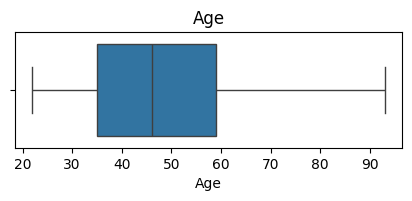

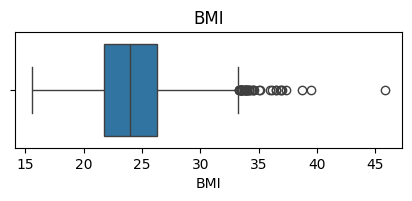

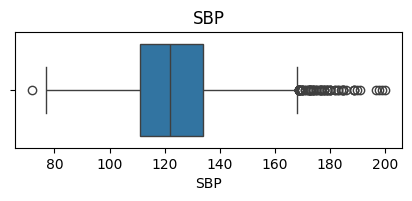

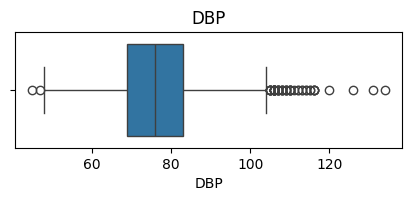

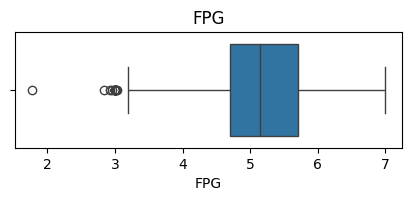

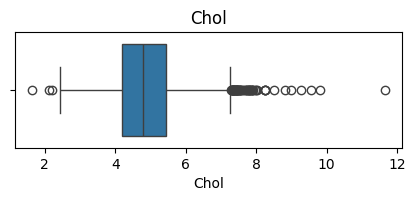

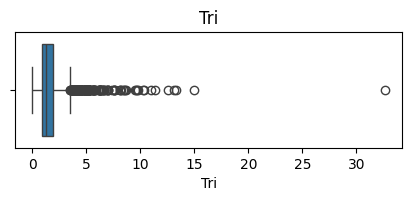

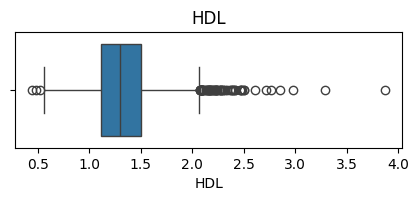

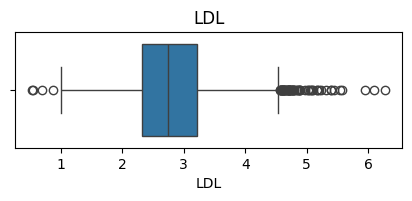

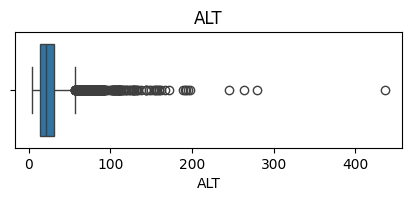

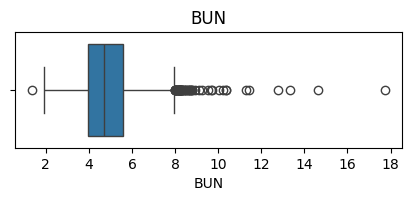

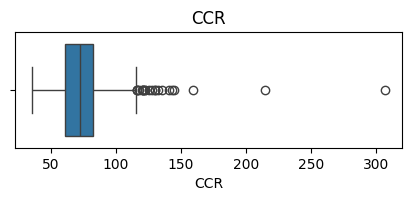

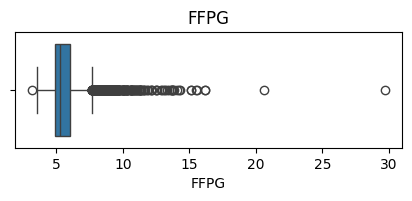

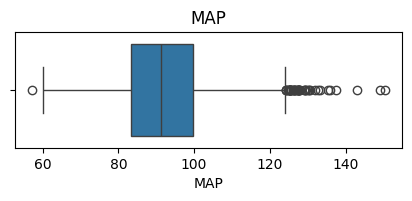

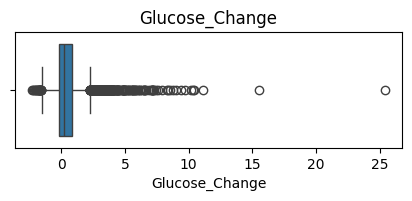

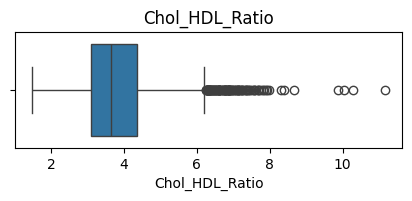

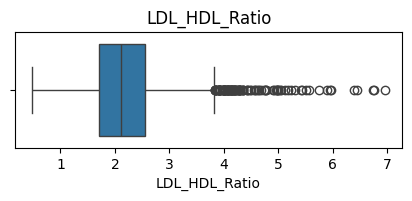

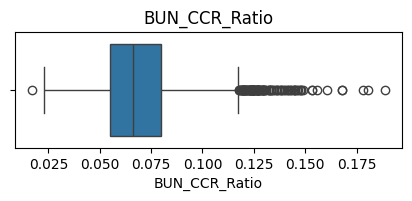

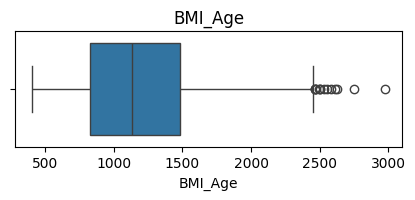

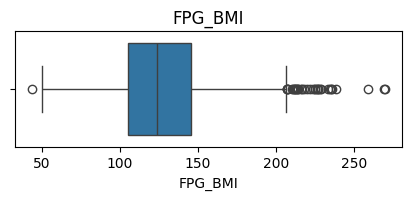

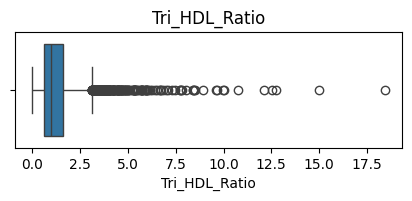

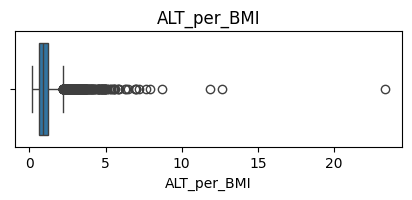

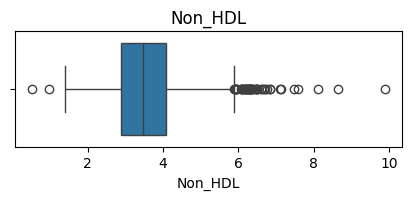

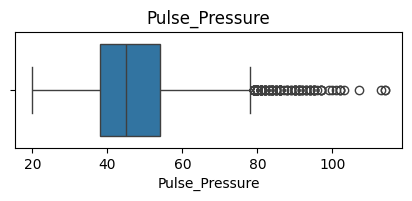

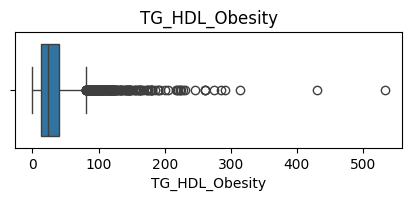

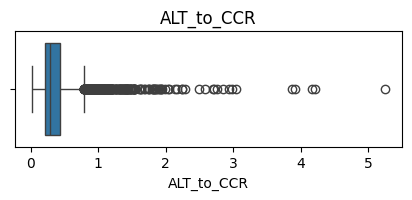

In [34]:
features = ['Age', 'BMI', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL', 'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'MAP', 'Glucose_Change', 'Chol_HDL_Ratio', 'LDL_HDL_Ratio',
            'BUN_CCR_Ratio', 'BMI_Age', 'FPG_BMI', 'Tri_HDL_Ratio', 'ALT_per_BMI', 'Non_HDL', 'Pulse_Pressure', 'TG_HDL_Obesity', 'ALT_to_CCR']

for col in features:
    plt.figure(figsize=(5, 1.5))
    sns.boxplot(x=master_data[col])
    plt.title(col)
    plt.show()

When handling outliers, if the models are tree-based models, we don't remove the outliers because these models are robust to outliers. However, if we build scale-sensitive models such as Logistic Regression and SVM, we have to scale the feature

In [35]:
# Handling outliers for BMI, SBP, DBP, Chol, Tri, HDL, LDL, ALT, BUN, CCR, FFPG, MAP, Glucose_Change, Chol_HDL_Ratio, LDL_HDL_Ratio, BUN_CCR_Ratio, BMI_Age, FPG_BMI,
# Tri_HDL_Ratio, ALT_per_BMI, Non_HDL, Pulse_Pressure, TG_HDL_Obesity, ALT_to_CCR,
# Use RobustScaler

# List of columns to scale
columns_to_scale = [
    'Age','BMI', 'SBP', 'DBP', 'Chol', 'Tri', 'HDL', 'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'MAP',
    'Glucose_Change', 'Chol_HDL_Ratio', 'LDL_HDL_Ratio', 'BUN_CCR_Ratio', 'BMI_Age',
    'FPG_BMI', 'Tri_HDL_Ratio', 'ALT_per_BMI', 'Non_HDL', 'Pulse_Pressure',
    'TG_HDL_Obesity', 'ALT_to_CCR'
]

# Logistic model
scaler_logistic = RobustScaler()
logistic_X_train[columns_to_scale] = scaler_logistic.fit_transform(logistic_X_train[columns_to_scale])
logistic_X_test[columns_to_scale] = scaler_logistic.transform(logistic_X_test[columns_to_scale])

# SVM model
scaler_svm = RobustScaler()
svm_X_train[columns_to_scale] = scaler_svm.fit_transform(svm_X_train[columns_to_scale])
svm_X_test[columns_to_scale] = scaler_svm.transform(svm_X_test[columns_to_scale])

# KNN model
scaler_knn = RobustScaler()
knn_X_train[columns_to_scale] = scaler_knn.fit_transform(knn_X_train[columns_to_scale])
knn_X_test[columns_to_scale] = scaler_knn.transform(knn_X_test[columns_to_scale])

# Neural network model
scaler_neural = RobustScaler()
neural_X_train[columns_to_scale] = scaler_neural.fit_transform(neural_X_train[columns_to_scale])
neural_X_test[columns_to_scale] = scaler_neural.transform(neural_X_test[columns_to_scale])

In [36]:
# Handling outliers for FPG
# Use StandardScaler

# List of columns to scale
columns_to_scale = ['FPG']

# Logistic model
scaler_logistic = StandardScaler()
logistic_X_train[columns_to_scale] = scaler_logistic.fit_transform(logistic_X_train[columns_to_scale])
logistic_X_test[columns_to_scale] = scaler_logistic.transform(logistic_X_test[columns_to_scale])

# SVM model
scaler_svm = StandardScaler()
svm_X_train[columns_to_scale] = scaler_svm.fit_transform(svm_X_train[columns_to_scale])
svm_X_test[columns_to_scale] = scaler_svm.transform(svm_X_test[columns_to_scale])

# KNN model
scaler_knn = StandardScaler()
knn_X_train[columns_to_scale] = scaler_knn.fit_transform(knn_X_train[columns_to_scale])
knn_X_test[columns_to_scale] = scaler_knn.transform(knn_X_test[columns_to_scale])

# Neural network model
scaler_neural = StandardScaler()
neural_X_train[columns_to_scale] = scaler_neural.fit_transform(neural_X_train[columns_to_scale])
neural_X_test[columns_to_scale] = scaler_neural.transform(neural_X_test[columns_to_scale])

In [37]:
decisiontree_X_train['Obesity_Class'] = decisiontree_X_train['Obesity_Class'].astype(int)
decisiontree_X_test['Obesity_Class'] = decisiontree_X_test['Obesity_Class'].astype(int)
randomforest_X_train['Obesity_Class'] = randomforest_X_train['Obesity_Class'].astype(int)
randomforest_X_test['Obesity_Class'] = randomforest_X_test['Obesity_Class'].astype(int)
xgboost_X_train['Obesity_Class'] = xgboost_X_train['Obesity_Class'].astype(int)
xgboost_X_test['Obesity_Class'] = xgboost_X_test['Obesity_Class'].astype(int)
lightgbm_X_train['Obesity_Class'] = lightgbm_X_train['Obesity_Class'].astype(int)
lightgbm_X_test['Obesity_Class'] = lightgbm_X_test['Obesity_Class'].astype(int)

In [38]:
logistic_X_test = logistic_X_test.rename(columns={'Impaired_FPG_Flag_True': 'Impaired_FPG_Flag_1'})
svm_X_test = svm_X_test.rename(columns={'Impaired_FPG_Flag_True': 'Impaired_FPG_Flag_1'})
knn_X_test = knn_X_test.rename(columns={'Impaired_FPG_Flag_True': 'Impaired_FPG_Flag_1'})
neural_X_test = neural_X_test.rename(columns={'Impaired_FPG_Flag_True': 'Impaired_FPG_Flag_1'})

## Baseline Models

In [39]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=3, random_state=42),
    "Dummy (Most Frequent)": DummyClassifier(strategy="most_frequent", random_state=42)
}

# Fit models and evaluate
results = []

for name, model in models.items():
    if name == "Logistic Regression":
        model.fit(logistic_X_train, logistic_y_train)
        y_pred = model.predict(logistic_X_test)
        y_prob = model.predict_proba(logistic_X_test)[:, 1]
    else:
        model.fit(decisiontree_X_train, decisiontree_y_train)
        y_pred = model.predict(decisiontree_X_test)
        y_prob = model.predict_proba(decisiontree_X_test)[:, 1] if hasattr(model, "predict_proba") else [0] * len(y_pred)
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(logistic_y_test, y_pred),
        "Precision": precision_score(logistic_y_test, y_pred, zero_division=0),
        "Recall": recall_score(logistic_y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(logistic_y_test, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(logistic_y_test, y_prob)
    })

# ---------- Display results ----------
results_df = pd.DataFrame(results)
print(results_df)

                   Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0    Logistic Regression  0.896512   0.810909  0.857692  0.833645  0.935500
1          Decision Tree  0.881395   0.786232  0.834615  0.809701  0.907946
2  Dummy (Most Frequent)  0.697674   0.000000  0.000000  0.000000  0.500000


## Feature Selection (Training Data)

### Logistic Regression

#### SelectKBest

In [40]:
# Step 1: Feature Selection (k = 20)
logistic_k = 20
logistic_selector = SelectKBest(score_func=f_classif, k=logistic_k)
logistic_X_train_selected = logistic_selector.fit_transform(logistic_X_train, logistic_y_train)
logistic_X_test_selected = logistic_selector.transform(logistic_X_test)

# Optional: Feature names
logistic_selected_features = logistic_X_train.columns[logistic_selector.get_support()]
print("Selected features:\n", logistic_selected_features.tolist())

# Step 2: Model Training
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(logistic_X_train_selected, logistic_y_train)

# Step 3: Prediction
logistic_y_pred = logistic_model.predict(logistic_X_test_selected)
logistic_y_proba = logistic_model.predict_proba(logistic_X_test_selected)[:, 1]

# Step 4: Evaluation Metrics
logistic_metrics = {
    "Recall": recall_score(logistic_y_test, logistic_y_pred),
    "Accuracy": accuracy_score(logistic_y_test, logistic_y_pred),
    "Precision": precision_score(logistic_y_test, logistic_y_pred),
    "F1 Score": f1_score(logistic_y_test, logistic_y_pred),
    "ROC AUC": roc_auc_score(logistic_y_test, logistic_y_proba)
}

# Display metrics in a table
logistic_results_df = pd.DataFrame([logistic_metrics])
print("\nModel Performance (Logistic Regression with SelectKBest k=20):")
print(logistic_results_df.to_string(index=False))

Selected features:
 ['Age', 'BMI', 'SBP', 'DBP', 'FPG', 'BUN', 'FFPG', 'MAP', 'Glucose_Change', 'BUN_CCR_Ratio', 'BMI_Age', 'FPG_BMI', 'Non_HDL', 'Pulse_Pressure', 'TG_HDL_Obesity', 'smoking_3', 'drinking_2', 'drinking_3', 'Obesity_Class_1', 'Impaired_FPG_Flag_1']

Model Performance (Logistic Regression with SelectKBest k=20):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.853846  0.895349   0.810219  0.831461 0.935577


#### Variance Threshold

In [41]:
# Step 1: Apply Variance Threshold
# You can adjust threshold (e.g., 0.01 or 0.05); here we use a low threshold to remove near-constant features
logistic_variance_threshold = 0.05
logistic_selector = VarianceThreshold(threshold=logistic_variance_threshold)
logistic_X_train_selected = logistic_selector.fit_transform(logistic_X_train)
logistic_X_test_selected = logistic_selector.transform(logistic_X_test)

# Optional: Get selected feature names
logistic_selected_features = logistic_X_train.columns[logistic_selector.get_support()]
print("Selected features:\n", logistic_selected_features.tolist())

# Step 2: Train Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(logistic_X_train_selected, logistic_y_train)

# Step 3: Prediction
logistic_y_pred = logistic_model.predict(logistic_X_test_selected)
logistic_y_proba = logistic_model.predict_proba(logistic_X_test_selected)[:, 1]

# Step 4: Evaluate
logistic_metrics = {
    "Recall": recall_score(logistic_y_test, logistic_y_pred),
    "Accuracy": accuracy_score(logistic_y_test, logistic_y_pred),
    "Precision": precision_score(logistic_y_test, logistic_y_pred),
    "F1 Score": f1_score(logistic_y_test, logistic_y_pred),
    "ROC AUC": roc_auc_score(logistic_y_test, logistic_y_proba)
}

# Step 5: Display results in a table
logistic_results_df = pd.DataFrame([logistic_metrics])
print("\nModel Performance (Logistic Regression with Variance Threshold):")
print(logistic_results_df.to_string(index=False))

Selected features:
 ['Age', 'BMI', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL', 'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'MAP', 'Glucose_Change', 'Chol_HDL_Ratio', 'LDL_HDL_Ratio', 'BUN_CCR_Ratio', 'BMI_Age', 'FPG_BMI', 'Tri_HDL_Ratio', 'ALT_per_BMI', 'Non_HDL', 'Pulse_Pressure', 'TG_HDL_Obesity', 'ALT_to_CCR', 'Gender_2', 'smoking_3', 'drinking_2', 'drinking_3', 'Obesity_Class_1', 'Impaired_FPG_Flag_1']

Model Performance (Logistic Regression with Variance Threshold):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.857692  0.896512   0.810909  0.833645 0.935397


#### Correlation Filter

In [42]:
# Step 1: Compute correlation matrix on training data
logistic_corr_matrix = logistic_X_train.corr().abs()

# Step 2: Upper triangle of correlation matrix
logistic_upper = logistic_corr_matrix.where(np.triu(np.ones(logistic_corr_matrix.shape), k=1).astype(bool))

# Step 3: Identify features to drop (correlation > threshold)
logistic_corr_threshold = 0.9
logistic_to_drop = [column for column in logistic_upper.columns if any(logistic_upper[column] > logistic_corr_threshold)]
print(f"Features dropped due to correlation > {logistic_corr_threshold}:\n", logistic_to_drop)

# Step 4: Drop highly correlated features
logistic_X_train_selected = logistic_X_train.drop(columns=logistic_to_drop)
logistic_X_test_selected = logistic_X_test.drop(columns=logistic_to_drop)

# Step 5: Train logistic regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(logistic_X_train_selected, logistic_y_train)

# Step 6: Prediction
logistic_y_pred = logistic_model.predict(logistic_X_test_selected)
logistic_y_proba = logistic_model.predict_proba(logistic_X_test_selected)[:, 1]

# Step 7: Evaluation metrics
logistic_metrics = {
    "Recall": recall_score(logistic_y_test, logistic_y_pred),
    "Accuracy": accuracy_score(logistic_y_test, logistic_y_pred),
    "Precision": precision_score(logistic_y_test, logistic_y_pred),
    "F1 Score": f1_score(logistic_y_test, logistic_y_pred),
    "ROC AUC": roc_auc_score(logistic_y_test, logistic_y_proba)
}

# Step 8: Display results in a table
logistic_results_df = pd.DataFrame([logistic_metrics])
print("\nModel Performance (Logistic Regression with Correlation Filter):")
print(logistic_results_df.to_string(index=False))

Features dropped due to correlation > 0.9:
 ['MAP', 'LDL_HDL_Ratio', 'BMI_Age', 'Tri_HDL_Ratio', 'ALT_per_BMI', 'Non_HDL', 'TG_HDL_Obesity', 'ALT_to_CCR', 'drinking_3']

Model Performance (Logistic Regression with Correlation Filter):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.857692  0.893023   0.802158  0.828996  0.93391


#### Recursive Feature Elimination (RFE)

In [43]:
# Step 1: Define model and number of features to select
logistic_estimator = LogisticRegression(max_iter=1000)
logistic_rfe_n_features = 20  # you can tune this value

# Step 2: Apply RFE
logistic_selector = RFE(estimator=logistic_estimator, n_features_to_select=logistic_rfe_n_features)
logistic_selector.fit(logistic_X_train, logistic_y_train)

# Step 3: Transform datasets
logistic_X_train_selected = logistic_selector.transform(logistic_X_train)
logistic_X_test_selected = logistic_selector.transform(logistic_X_test)

# Optional: Feature names
logistic_selected_features = logistic_X_train.columns[logistic_selector.support_]
print("Selected features (RFE):\n", logistic_selected_features.tolist())

# Step 4: Train model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(logistic_X_train_selected, logistic_y_train)

# Step 5: Predict
logistic_y_pred = logistic_model.predict(logistic_X_test_selected)
logistic_y_proba = logistic_model.predict_proba(logistic_X_test_selected)[:, 1]

# Step 6: Evaluate
logistic_metrics = {
    "Recall": recall_score(logistic_y_test, logistic_y_pred),
    "Accuracy": accuracy_score(logistic_y_test, logistic_y_pred),
    "Precision": precision_score(logistic_y_test, logistic_y_pred),
    "F1 Score": f1_score(logistic_y_test, logistic_y_pred),
    "ROC AUC": roc_auc_score(logistic_y_test, logistic_y_proba)
}

# Step 7: Display results
logistic_results_df = pd.DataFrame([logistic_metrics])
print("\nModel Performance (Logistic Regression with RFE):")
print(logistic_results_df.to_string(index=False))

Selected features (RFE):
 ['Age', 'BMI', 'DBP', 'FPG', 'HDL', 'ALT', 'FFPG', 'MAP', 'Glucose_Change', 'Chol_HDL_Ratio', 'BMI_Age', 'FPG_BMI', 'ALT_per_BMI', 'Non_HDL', 'Pulse_Pressure', 'smoking_3', 'drinking_2', 'drinking_3', 'Obesity_Class_3', 'Impaired_FPG_Flag_1']

Model Performance (Logistic Regression with RFE):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.869231  0.896512    0.80427   0.83549 0.936487


#### Sequential Feature Selection (SFS)

In [44]:
# Step 1: Define model and number of features to select
logistic_estimator = LogisticRegression(max_iter=1000)
logistic_sfs_n_features = 20  # You can adjust this

# Step 2: Apply SFS (forward selection)
logistic_selector = SequentialFeatureSelector(
    estimator=logistic_estimator,
    n_features_to_select=logistic_sfs_n_features,
    direction='forward',
    scoring='recall',
    cv=5,
    n_jobs=-1
)
logistic_selector.fit(logistic_X_train, logistic_y_train)

# Step 3: Transform datasets
logistic_X_train_selected = logistic_selector.transform(logistic_X_train)
logistic_X_test_selected = logistic_selector.transform(logistic_X_test)

# Optional: Feature names
logistic_selected_features = logistic_X_train.columns[logistic_selector.get_support()]
print("Selected features (SFS):\n", logistic_selected_features.tolist())

# Step 4: Train logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(logistic_X_train_selected, logistic_y_train)

# Step 5: Predict
logistic_y_pred = logistic_model.predict(logistic_X_test_selected)
logistic_y_proba = logistic_model.predict_proba(logistic_X_test_selected)[:, 1]

# Step 6: Evaluate
logistic_metrics = {
    "Recall": recall_score(logistic_y_test, logistic_y_pred),
    "Accuracy": accuracy_score(logistic_y_test, logistic_y_pred),
    "Precision": precision_score(logistic_y_test, logistic_y_pred),
    "F1 Score": f1_score(logistic_y_test, logistic_y_pred),
    "ROC AUC": roc_auc_score(logistic_y_test, logistic_y_proba)
}

# Step 7: Display results in a table
logistic_results_df = pd.DataFrame([logistic_metrics])
print("\nModel Performance (Logistic Regression with SFS):")
print(logistic_results_df.to_string(index=False))

Selected features (SFS):
 ['Age', 'HDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'Chol_HDL_Ratio', 'LDL_HDL_Ratio', 'FPG_BMI', 'Tri_HDL_Ratio', 'ALT_per_BMI', 'smoking_2', 'smoking_3', 'drinking_2', 'drinking_3', 'family_history_1', 'Obesity_Class_1', 'Obesity_Class_2', 'Obesity_Class_3', 'Obesity_Class_4']

Model Performance (Logistic Regression with SFS):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.853846  0.901163   0.825279  0.839319 0.934692


#### L1 regularization (Lasso)

In [45]:
# Step 1: Train logistic regression with L1 regularization
logistic_l1_model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=1.0)
logistic_selector = SelectFromModel(estimator=logistic_l1_model, prefit=False)

# Fit on training data
logistic_selector.fit(logistic_X_train, logistic_y_train)

# Step 2: Transform datasets to selected features
logistic_X_train_selected = logistic_selector.transform(logistic_X_train)
logistic_X_test_selected = logistic_selector.transform(logistic_X_test)

# Optional: Get selected feature names
logistic_selected_features = logistic_X_train.columns[logistic_selector.get_support()]
print("Selected features (L1 Regularization):\n", logistic_selected_features.tolist())

# Step 3: Retrain model on selected features
logistic_final_model = LogisticRegression(max_iter=1000)
logistic_final_model.fit(logistic_X_train_selected, logistic_y_train)

# Step 4: Predict
logistic_y_pred = logistic_final_model.predict(logistic_X_test_selected)
logistic_y_proba = logistic_final_model.predict_proba(logistic_X_test_selected)[:, 1]

# Step 5: Evaluate
logistic_metrics = {
    "Recall": recall_score(logistic_y_test, logistic_y_pred),
    "Accuracy": accuracy_score(logistic_y_test, logistic_y_pred),
    "Precision": precision_score(logistic_y_test, logistic_y_pred),
    "F1 Score": f1_score(logistic_y_test, logistic_y_pred),
    "ROC AUC": roc_auc_score(logistic_y_test, logistic_y_proba)
}

# Step 6: Display results
logistic_results_df = pd.DataFrame([logistic_metrics])
print("\nModel Performance (Logistic Regression with L1 Feature Selection):")
print(logistic_results_df.to_string(index=False))

Selected features (L1 Regularization):
 ['Age', 'BMI', 'DBP', 'FPG', 'HDL', 'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'MAP', 'Chol_HDL_Ratio', 'LDL_HDL_Ratio', 'FPG_BMI', 'Tri_HDL_Ratio', 'ALT_per_BMI', 'Non_HDL', 'Pulse_Pressure', 'TG_HDL_Obesity', 'Gender_2', 'smoking_2', 'smoking_3', 'drinking_2', 'drinking_3', 'family_history_1', 'Obesity_Class_1', 'Impaired_FPG_Flag_1']

Model Performance (Logistic Regression with L1 Feature Selection):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.857692  0.894186   0.805054   0.83054 0.935378


Since RFE produces the best recall, we choose RFE for logistic regression

In [46]:
# Step 1: Define estimator and number of features to select
logistic_estimator = LogisticRegression(max_iter=1000)
logistic_rfe_n_features = 20  # Adjust this as needed

# Step 2: Apply RFE
logistic_selector = RFE(estimator=logistic_estimator, n_features_to_select=logistic_rfe_n_features)
logistic_selector.fit(logistic_X_train, logistic_y_train)

# Step 3: Create new train and test sets with selected features
logistic_X_train_selected = logistic_X_train.loc[:, logistic_selector.get_support()]
logistic_X_test_selected = logistic_X_test.loc[:, logistic_selector.get_support()]

# Optional: Print selected feature names
logistic_selected_features = logistic_X_train_selected.columns
print("Selected features using RFE:\n", logistic_selected_features.tolist())

Selected features using RFE:
 ['Age', 'BMI', 'DBP', 'FPG', 'HDL', 'ALT', 'FFPG', 'MAP', 'Glucose_Change', 'Chol_HDL_Ratio', 'BMI_Age', 'FPG_BMI', 'ALT_per_BMI', 'Non_HDL', 'Pulse_Pressure', 'smoking_3', 'drinking_2', 'drinking_3', 'Obesity_Class_3', 'Impaired_FPG_Flag_1']


### K-Neareast Neighbors (KNN)

#### SelectKBest

In [47]:
# Step 1: Feature Selection (k = 20)
knn_k = 20
knn_selector = SelectKBest(score_func=f_classif, k=knn_k)
knn_X_train_selected = knn_selector.fit_transform(knn_X_train, knn_y_train)
knn_X_test_selected = knn_selector.transform(knn_X_test)

# Optional: Feature names
knn_selected_features = knn_X_train.columns[knn_selector.get_support()]
print("Selected features:\n", knn_selected_features.tolist())

# Step 2: Model Training
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(knn_X_train_selected, knn_y_train)

# Step 3: Prediction
knn_y_pred = knn_model.predict(knn_X_test_selected)
knn_y_proba = knn_model.predict_proba(knn_X_test_selected)[:, 1]

# Step 4: Evaluation Metrics
knn_metrics = {
    "Recall": recall_score(knn_y_test, knn_y_pred),
    "Accuracy": accuracy_score(knn_y_test, knn_y_pred),
    "Precision": precision_score(knn_y_test, knn_y_pred),
    "F1 Score": f1_score(knn_y_test, knn_y_pred),
    "ROC AUC": roc_auc_score(knn_y_test, knn_y_proba)
}

# Display metrics in a table
knn_results_df = pd.DataFrame([knn_metrics])
print("\nModel Performance (KNN with SelectKBest k=20):")
print(knn_results_df.to_string(index=False))

Selected features:
 ['Age', 'BMI', 'SBP', 'DBP', 'FPG', 'BUN', 'FFPG', 'MAP', 'Glucose_Change', 'BUN_CCR_Ratio', 'BMI_Age', 'FPG_BMI', 'Non_HDL', 'Pulse_Pressure', 'TG_HDL_Obesity', 'smoking_3', 'drinking_2', 'drinking_3', 'Obesity_Class_1', 'Impaired_FPG_Flag_1']

Model Performance (KNN with SelectKBest k=20):
 Recall  Accuracy  Precision  F1 Score  ROC AUC
   0.85  0.873256    0.75945  0.802178  0.90508


#### Variance Threshold

In [48]:
# Step 1: Feature Selection (Variance Threshold)
knn_variance_threshold = 0.01  # You can tune this
knn_selector = VarianceThreshold(threshold=knn_variance_threshold)
knn_X_train_selected = knn_selector.fit_transform(knn_X_train)
knn_X_test_selected = knn_selector.transform(knn_X_test)

# Optional: Feature names
knn_selected_features = knn_X_train.columns[knn_selector.get_support()]
print("Selected features (Variance Threshold):\n", knn_selected_features.tolist())

# Step 2: Model Training
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(knn_X_train_selected, knn_y_train)

# Step 3: Prediction
knn_y_pred = knn_model.predict(knn_X_test_selected)
knn_y_proba = knn_model.predict_proba(knn_X_test_selected)[:, 1]

# Step 4: Evaluation Metrics
knn_metrics = {
    "Recall": recall_score(knn_y_test, knn_y_pred),
    "Accuracy": accuracy_score(knn_y_test, knn_y_pred),
    "Precision": precision_score(knn_y_test, knn_y_pred),
    "F1 Score": f1_score(knn_y_test, knn_y_pred),
    "ROC AUC": roc_auc_score(knn_y_test, knn_y_proba)
}

# Display metrics in a table
knn_results_df = pd.DataFrame([knn_metrics])
print("\nModel Performance (KNN with Variance Threshold):")
print(knn_results_df.to_string(index=False))

Selected features (Variance Threshold):
 ['Age', 'BMI', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL', 'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'MAP', 'Glucose_Change', 'Chol_HDL_Ratio', 'LDL_HDL_Ratio', 'BUN_CCR_Ratio', 'BMI_Age', 'FPG_BMI', 'Tri_HDL_Ratio', 'ALT_per_BMI', 'Non_HDL', 'Pulse_Pressure', 'TG_HDL_Obesity', 'ALT_to_CCR', 'Gender_2', 'smoking_2', 'smoking_3', 'drinking_2', 'drinking_3', 'family_history_1', 'Obesity_Class_1', 'Obesity_Class_2', 'Impaired_FPG_Flag_1']

Model Performance (KNN with Variance Threshold):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.830769  0.833721   0.685714  0.751304 0.901724


#### Correlation Filter

In [49]:
# Step 1: Compute correlation matrix on training set
knn_corr_matrix = knn_X_train.corr().abs()

# Step 2: Get upper triangle of the correlation matrix
knn_upper = knn_corr_matrix.where(np.triu(np.ones(knn_corr_matrix.shape), k=1).astype(bool))

# Step 3: Identify highly correlated features to drop
knn_corr_threshold = 0.9
knn_to_drop = [column for column in knn_upper.columns if any(knn_upper[column] > knn_corr_threshold)]
print(f"Features dropped due to correlation > {knn_corr_threshold}:\n", knn_to_drop)

# Step 4: Drop from both train and test sets
knn_X_train_selected = knn_X_train.drop(columns=knn_to_drop)
knn_X_test_selected = knn_X_test.drop(columns=knn_to_drop)

# Optional: Feature names after correlation filter
knn_selected_features = knn_X_train_selected.columns
print("Selected features (Correlation Filter):\n", knn_selected_features.tolist())

# Step 5: Train KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(knn_X_train_selected, knn_y_train)

# Step 6: Predict
knn_y_pred = knn_model.predict(knn_X_test_selected)
knn_y_proba = knn_model.predict_proba(knn_X_test_selected)[:, 1]

# Step 7: Evaluation metrics
knn_metrics = {
    "Recall": recall_score(knn_y_test, knn_y_pred),
    "Accuracy": accuracy_score(knn_y_test, knn_y_pred),
    "Precision": precision_score(knn_y_test, knn_y_pred),
    "F1 Score": f1_score(knn_y_test, knn_y_pred),
    "ROC AUC": roc_auc_score(knn_y_test, knn_y_proba)
}

# Step 8: Display metrics in a table
knn_results_df = pd.DataFrame([knn_metrics])
print("\nModel Performance (KNN with Correlation Filter):")
print(knn_results_df.to_string(index=False))

Features dropped due to correlation > 0.9:
 ['MAP', 'LDL_HDL_Ratio', 'BMI_Age', 'Tri_HDL_Ratio', 'ALT_per_BMI', 'Non_HDL', 'TG_HDL_Obesity', 'ALT_to_CCR', 'drinking_3']
Selected features (Correlation Filter):
 ['Age', 'BMI', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL', 'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'Glucose_Change', 'Chol_HDL_Ratio', 'BUN_CCR_Ratio', 'FPG_BMI', 'Pulse_Pressure', 'Gender_2', 'smoking_2', 'smoking_3', 'drinking_2', 'family_history_1', 'Obesity_Class_1', 'Obesity_Class_2', 'Obesity_Class_3', 'Obesity_Class_4', 'Impaired_FPG_Flag_1']

Model Performance (KNN with Correlation Filter):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.807692  0.844186   0.714286  0.758123    0.896


#### Sequential Feature Selection (SFS)

In [50]:
# Step 1: Define estimator and number of features to select
knn_estimator = KNeighborsClassifier(n_neighbors=5)
knn_sfs_n_features = 20  # You can adjust this

# Step 2: Apply Sequential Feature Selector (forward selection)
knn_selector = SequentialFeatureSelector(
    estimator=knn_estimator,
    n_features_to_select=knn_sfs_n_features,
    direction='forward',
    scoring='recall',
    cv=5,
    n_jobs=-1
)
knn_selector.fit(knn_X_train, knn_y_train)

# Step 3: Transform datasets
knn_X_train_selected = knn_selector.transform(knn_X_train)
knn_X_test_selected = knn_selector.transform(knn_X_test)

# Optional: Feature names
knn_selected_features = knn_X_train.columns[knn_selector.get_support()]
print("Selected features (SFS):\n", knn_selected_features.tolist())

# Step 4: Train KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(knn_X_train_selected, knn_y_train)

# Step 5: Prediction
knn_y_pred = knn_model.predict(knn_X_test_selected)
knn_y_proba = knn_model.predict_proba(knn_X_test_selected)[:, 1]

# Step 6: Evaluation metrics
knn_metrics = {
    "Recall": recall_score(knn_y_test, knn_y_pred),
    "Accuracy": accuracy_score(knn_y_test, knn_y_pred),
    "Precision": precision_score(knn_y_test, knn_y_pred),
    "F1 Score": f1_score(knn_y_test, knn_y_pred),
    "ROC AUC": roc_auc_score(knn_y_test, knn_y_proba)
}

# Step 7: Display results in a table
knn_results_df = pd.DataFrame([knn_metrics])
print("\nModel Performance (KNN with SFS):")
print(knn_results_df.to_string(index=False))

Selected features (SFS):
 ['Age', 'SBP', 'Tri', 'ALT', 'CCR', 'FFPG', 'BUN_CCR_Ratio', 'BMI_Age', 'FPG_BMI', 'Tri_HDL_Ratio', 'Non_HDL', 'Pulse_Pressure', 'TG_HDL_Obesity', 'smoking_2', 'smoking_3', 'drinking_2', 'family_history_1', 'Obesity_Class_2', 'Obesity_Class_3', 'Obesity_Class_4']

Model Performance (KNN with SFS):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.803846   0.82093   0.669872  0.730769 0.885346


Since SelectKBest produces the best recall, we choose SelectKBest for KNN

In [51]:
# Step 1: Set number of features to select
knn_k = 20  # You can adjust this

# Step 2: Apply SelectKBest with ANOVA F-test
knn_selector = SelectKBest(score_func=f_classif, k=knn_k)
knn_selector.fit(knn_X_train, knn_y_train)

# Step 3: Get mask of selected features
knn_support_mask = knn_selector.get_support()
knn_selected_feature_names = knn_X_train.columns[knn_support_mask]

# Step 4: Create new DataFrames with selected features
knn_X_train_selected = knn_X_train.loc[:, knn_selected_feature_names]
knn_X_test_selected = knn_X_test.loc[:, knn_selected_feature_names]

# Optional: Print selected feature names
print("Selected features for KNN using SelectKBest:\n", knn_selected_feature_names.tolist())

Selected features for KNN using SelectKBest:
 ['Age', 'BMI', 'SBP', 'DBP', 'FPG', 'BUN', 'FFPG', 'MAP', 'Glucose_Change', 'BUN_CCR_Ratio', 'BMI_Age', 'FPG_BMI', 'Non_HDL', 'Pulse_Pressure', 'TG_HDL_Obesity', 'smoking_3', 'drinking_2', 'drinking_3', 'Obesity_Class_1', 'Impaired_FPG_Flag_1']


### Support Vector Machine (SVM)

#### SelectKBest

In [52]:
# Step 1: Feature Selection (k = 20)
svm_k = 20
svm_selector = SelectKBest(score_func=f_classif, k=svm_k)
svm_selector.fit(svm_X_train, svm_y_train)

# Create DataFrames with selected features
svm_selected_features = svm_X_train.columns[svm_selector.get_support()]
svm_X_train_selected = svm_X_train.loc[:, svm_selected_features]
svm_X_test_selected = svm_X_test.loc[:, svm_selected_features]

print("Selected features for SVM using SelectKBest:\n", svm_selected_features.tolist())

# Step 2: Train SVM model
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(svm_X_train_selected, svm_y_train)

# Step 3: Predict
svm_y_pred = svm_model.predict(svm_X_test_selected)
svm_y_proba = svm_model.predict_proba(svm_X_test_selected)[:, 1]

# Step 4: Evaluation Metrics
svm_metrics = {
    "Recall": recall_score(svm_y_test, svm_y_pred),
    "Accuracy": accuracy_score(svm_y_test, svm_y_pred),
    "Precision": precision_score(svm_y_test, svm_y_pred),
    "F1 Score": f1_score(svm_y_test, svm_y_pred),
    "ROC AUC": roc_auc_score(svm_y_test, svm_y_proba)
}

# Step 5: Display results in a table
svm_results_df = pd.DataFrame([svm_metrics])
print("\nModel Performance (SVM with SelectKBest k=20):")
print(svm_results_df.to_string(index=False))

Selected features for SVM using SelectKBest:
 ['Age', 'BMI', 'SBP', 'DBP', 'FPG', 'BUN', 'FFPG', 'MAP', 'Glucose_Change', 'BUN_CCR_Ratio', 'BMI_Age', 'FPG_BMI', 'Non_HDL', 'Pulse_Pressure', 'TG_HDL_Obesity', 'smoking_3', 'drinking_2', 'drinking_3', 'Obesity_Class_1', 'Impaired_FPG_Flag_1']

Model Performance (SVM with SelectKBest k=20):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.838462  0.894186   0.816479  0.827324 0.931667


#### Variance Threshold

In [53]:
# Step 1: Apply Variance Threshold
svm_variance_threshold = 0.01  # You can adjust this value
svm_selector = VarianceThreshold(threshold=svm_variance_threshold)
svm_selector.fit(svm_X_train)

# Step 2: Get selected feature names and transform data
svm_selected_features = svm_X_train.columns[svm_selector.get_support()]
svm_X_train_selected = svm_X_train.loc[:, svm_selected_features]
svm_X_test_selected = svm_X_test.loc[:, svm_selected_features]

print("Selected features for SVM using Variance Threshold:\n", svm_selected_features.tolist())

# Step 3: Train SVM model
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(svm_X_train_selected, svm_y_train)

# Step 4: Prediction
svm_y_pred = svm_model.predict(svm_X_test_selected)
svm_y_proba = svm_model.predict_proba(svm_X_test_selected)[:, 1]

# Step 5: Evaluation Metrics
svm_metrics = {
    "Recall": recall_score(svm_y_test, svm_y_pred),
    "Accuracy": accuracy_score(svm_y_test, svm_y_pred),
    "Precision": precision_score(svm_y_test, svm_y_pred),
    "F1 Score": f1_score(svm_y_test, svm_y_pred),
    "ROC AUC": roc_auc_score(svm_y_test, svm_y_proba)
}

# Step 6: Display results in a table
svm_results_df = pd.DataFrame([svm_metrics])
print("\nModel Performance (SVM with Variance Threshold):")
print(svm_results_df.to_string(index=False))

Selected features for SVM using Variance Threshold:
 ['Age', 'BMI', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL', 'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'MAP', 'Glucose_Change', 'Chol_HDL_Ratio', 'LDL_HDL_Ratio', 'BUN_CCR_Ratio', 'BMI_Age', 'FPG_BMI', 'Tri_HDL_Ratio', 'ALT_per_BMI', 'Non_HDL', 'Pulse_Pressure', 'TG_HDL_Obesity', 'ALT_to_CCR', 'Gender_2', 'smoking_2', 'smoking_3', 'drinking_2', 'drinking_3', 'family_history_1', 'Obesity_Class_1', 'Obesity_Class_2', 'Impaired_FPG_Flag_1']

Model Performance (SVM with Variance Threshold):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.823077   0.89186   0.819923  0.821497 0.929064


In [54]:
# Step 1: Compute correlation matrix on training data
svm_corr_matrix = svm_X_train.corr().abs()

# Step 2: Get upper triangle of correlation matrix
svm_upper = svm_corr_matrix.where(np.triu(np.ones(svm_corr_matrix.shape), k=1).astype(bool))

# Step 3: Identify highly correlated features to drop
svm_corr_threshold = 0.9
svm_to_drop = [column for column in svm_upper.columns if any(svm_upper[column] > svm_corr_threshold)]
print(f"Features dropped due to correlation > {svm_corr_threshold}:\n", svm_to_drop)

# Step 4: Drop selected features
svm_X_train_selected = svm_X_train.drop(columns=svm_to_drop)
svm_X_test_selected = svm_X_test.drop(columns=svm_to_drop)

# Optional: Print final selected feature names
svm_selected_features = svm_X_train_selected.columns
print("Selected features for SVM using Correlation Filter:\n", svm_selected_features.tolist())

# Step 5: Train SVM model
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(svm_X_train_selected, svm_y_train)

# Step 6: Prediction
svm_y_pred = svm_model.predict(svm_X_test_selected)
svm_y_proba = svm_model.predict_proba(svm_X_test_selected)[:, 1]

# Step 7: Evaluation metrics
svm_metrics = {
    "Recall": recall_score(svm_y_test, svm_y_pred),
    "Accuracy": accuracy_score(svm_y_test, svm_y_pred),
    "Precision": precision_score(svm_y_test, svm_y_pred),
    "F1 Score": f1_score(svm_y_test, svm_y_pred),
    "ROC AUC": roc_auc_score(svm_y_test, svm_y_proba)
}

# Step 8: Display metrics in a table
svm_results_df = pd.DataFrame([svm_metrics])
print("\nModel Performance (SVM with Correlation Filter):")
print(svm_results_df.to_string(index=False))

Features dropped due to correlation > 0.9:
 ['MAP', 'LDL_HDL_Ratio', 'BMI_Age', 'Tri_HDL_Ratio', 'ALT_per_BMI', 'Non_HDL', 'TG_HDL_Obesity', 'ALT_to_CCR', 'drinking_3']
Selected features for SVM using Correlation Filter:
 ['Age', 'BMI', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL', 'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'Glucose_Change', 'Chol_HDL_Ratio', 'BUN_CCR_Ratio', 'FPG_BMI', 'Pulse_Pressure', 'Gender_2', 'smoking_2', 'smoking_3', 'drinking_2', 'family_history_1', 'Obesity_Class_1', 'Obesity_Class_2', 'Obesity_Class_3', 'Obesity_Class_4', 'Impaired_FPG_Flag_1']

Model Performance (SVM with Correlation Filter):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.826923  0.896512   0.830116  0.828516 0.929705


#### Recursive Feature Elimination (RFE)

In [55]:
# Step 1: Define estimator and number of features to select
svm_estimator = SVC(kernel='linear')  # linear kernel required for RFE to access coef_
svm_rfe_n_features = 20  # You can change this

# Step 2: Apply RFE
svm_selector = RFE(estimator=svm_estimator, n_features_to_select=svm_rfe_n_features)
svm_selector.fit(svm_X_train, svm_y_train)

# Step 3: Select features
svm_selected_features = svm_X_train.columns[svm_selector.support_]
svm_X_train_selected = svm_X_train.loc[:, svm_selected_features]
svm_X_test_selected = svm_X_test.loc[:, svm_selected_features]

print("Selected features using RFE for SVM:\n", svm_selected_features.tolist())

# Step 4: Train final SVM model
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(svm_X_train_selected, svm_y_train)

# Step 5: Prediction
svm_y_pred = svm_model.predict(svm_X_test_selected)
svm_y_proba = svm_model.predict_proba(svm_X_test_selected)[:, 1]

# Step 6: Evaluation metrics
svm_metrics = {
    "Recall": recall_score(svm_y_test, svm_y_pred),
    "Accuracy": accuracy_score(svm_y_test, svm_y_pred),
    "Precision": precision_score(svm_y_test, svm_y_pred),
    "F1 Score": f1_score(svm_y_test, svm_y_pred),
    "ROC AUC": roc_auc_score(svm_y_test, svm_y_proba)
}

# Step 7: Display results in a table
svm_results_df = pd.DataFrame([svm_metrics])
print("\nModel Performance (SVM with RFE):")
print(svm_results_df.to_string(index=False))

Selected features using RFE for SVM:
 ['Age', 'BMI', 'SBP', 'DBP', 'HDL', 'ALT', 'FFPG', 'MAP', 'Glucose_Change', 'Chol_HDL_Ratio', 'FPG_BMI', 'ALT_per_BMI', 'Pulse_Pressure', 'smoking_3', 'drinking_2', 'drinking_3', 'Obesity_Class_1', 'Obesity_Class_2', 'Obesity_Class_3', 'Impaired_FPG_Flag_1']

Model Performance (SVM with RFE):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.826923  0.886047   0.802239  0.814394 0.931295


#### L1 regularization

In [56]:
# Step 1: L1-based feature selector (LinearSVC with L1 penalty)
svm_l1_model = LinearSVC(penalty='l1', dual=False, C=1.0, max_iter=1000)
svm_selector = SelectFromModel(estimator=svm_l1_model)
svm_selector.fit(svm_X_train, svm_y_train)

# Step 2: Get selected features and reduce train/test sets
svm_selected_features = svm_X_train.columns[svm_selector.get_support()]
svm_X_train_selected = svm_X_train.loc[:, svm_selected_features]
svm_X_test_selected = svm_X_test.loc[:, svm_selected_features]

print("Selected features using L1-Regularized SVM:\n", svm_selected_features.tolist())

# Step 3: Train final SVM model (e.g., RBF kernel)
svm_final_model = SVC(kernel='rbf', probability=True)
svm_final_model.fit(svm_X_train_selected, svm_y_train)

# Step 4: Predict
svm_y_pred = svm_final_model.predict(svm_X_test_selected)
svm_y_proba = svm_final_model.predict_proba(svm_X_test_selected)[:, 1]

# Step 5: Evaluation metrics
svm_metrics = {
    "Recall": recall_score(svm_y_test, svm_y_pred),
    "Accuracy": accuracy_score(svm_y_test, svm_y_pred),
    "Precision": precision_score(svm_y_test, svm_y_pred),
    "F1 Score": f1_score(svm_y_test, svm_y_pred),
    "ROC AUC": roc_auc_score(svm_y_test, svm_y_proba)
}

# Step 6: Display metrics in a table
svm_results_df = pd.DataFrame([svm_metrics])
print("\nModel Performance (SVM with L1-based Feature Selection):")
print(svm_results_df.to_string(index=False))

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Selected features using L1-Regularized SVM:
 ['Age', 'BMI', 'SBP', 'DBP', 'FPG', 'Tri', 'HDL', 'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'MAP', 'Glucose_Change', 'Chol_HDL_Ratio', 'BMI_Age', 'FPG_BMI', 'Tri_HDL_Ratio', 'ALT_per_BMI', 'Non_HDL', 'Pulse_Pressure', 'ALT_to_CCR', 'Gender_2', 'smoking_2', 'smoking_3', 'drinking_2', 'drinking_3', 'Obesity_Class_1', 'Obesity_Class_2', 'Obesity_Class_3', 'Impaired_FPG_Flag_1']

Model Performance (SVM with L1-based Feature Selection):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.826923  0.889535   0.811321  0.819048 0.928641


Since SelectKBest produces the best recall, we choose SelectKBest for SVM

In [57]:
# Step 1: Set number of features to select
svm_k = 20  # You can adjust this based on tuning

# Step 2: Apply SelectKBest
svm_selector = SelectKBest(score_func=f_classif, k=svm_k)
svm_selector.fit(svm_X_train, svm_y_train)

# Step 3: Get selected feature names
svm_selected_features = svm_X_train.columns[svm_selector.get_support()]

# Step 4: Create new DataFrames with selected features
svm_X_train_selected = svm_X_train.loc[:, svm_selected_features]
svm_X_test_selected = svm_X_test.loc[:, svm_selected_features]

# Optional: Display selected features
print("Selected features for SVM using SelectKBest:\n", svm_selected_features.tolist())

Selected features for SVM using SelectKBest:
 ['Age', 'BMI', 'SBP', 'DBP', 'FPG', 'BUN', 'FFPG', 'MAP', 'Glucose_Change', 'BUN_CCR_Ratio', 'BMI_Age', 'FPG_BMI', 'Non_HDL', 'Pulse_Pressure', 'TG_HDL_Obesity', 'smoking_3', 'drinking_2', 'drinking_3', 'Obesity_Class_1', 'Impaired_FPG_Flag_1']


### Neural Networks

In [58]:
bool_cols = ['Gender_2', 'smoking_2', 'smoking_3', 'drinking_2', 'drinking_3', 'family_history_1', 'Obesity_Class_1', 'Obesity_Class_2', 'Obesity_Class_3', 'Obesity_Class_4', 'Impaired_FPG_Flag_1']

neural_X_train[bool_cols] = neural_X_train[bool_cols].astype(int)
neural_X_test[bool_cols] = neural_X_test[bool_cols].astype(int)

#### SelectKBest

In [59]:
# Step 1: Feature Selection (k = 20)
neural_k = 20
neural_selector = SelectKBest(score_func=f_classif, k=neural_k)
neural_selector.fit(neural_X_train, neural_y_train)

# Get selected feature names and reduce datasets
neural_selected_features = neural_X_train.columns[neural_selector.get_support()]
neural_X_train_selected = neural_X_train.loc[:, neural_selected_features]
neural_X_test_selected = neural_X_test.loc[:, neural_selected_features]

print("Selected features for Neural Network using SelectKBest:\n", neural_selected_features.tolist())

# Step 2: Build Neural Network Model
neural_model = Sequential([
    Dense(32, activation='relu', input_shape=(neural_X_train_selected.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

neural_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=[Recall()])

# Step 3: Train the model
neural_model.fit(neural_X_train_selected, neural_y_train, epochs=50, batch_size=32, verbose=0)

# Step 4: Predict
neural_y_proba = neural_model.predict(neural_X_test_selected).flatten()
neural_y_pred = (neural_y_proba >= 0.5).astype(int)

# Step 5: Evaluation Metrics
neural_metrics = {
    "Recall": recall_score(neural_y_test, neural_y_pred),
    "Accuracy": accuracy_score(neural_y_test, neural_y_pred),
    "Precision": precision_score(neural_y_test, neural_y_pred),
    "F1 Score": f1_score(neural_y_test, neural_y_pred),
    "ROC AUC": roc_auc_score(neural_y_test, neural_y_proba)
}

# Step 6: Display metrics in a table
neural_results_df = pd.DataFrame([neural_metrics])
print("\nModel Performance (Neural Network with SelectKBest k=20):")
print(neural_results_df.to_string(index=False))

Selected features for Neural Network using SelectKBest:
 ['Age', 'BMI', 'SBP', 'DBP', 'FPG', 'BUN', 'FFPG', 'MAP', 'Glucose_Change', 'BUN_CCR_Ratio', 'BMI_Age', 'FPG_BMI', 'Non_HDL', 'Pulse_Pressure', 'TG_HDL_Obesity', 'smoking_3', 'drinking_2', 'drinking_3', 'Obesity_Class_1', 'Impaired_FPG_Flag_1']


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Model Performance (Neural Network with SelectKBest k=20):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.780769  0.894186    0.85654  0.816901   0.9285


#### Variance Threshold

In [60]:
# Step 1: Apply Variance Threshold
neural_variance_threshold = 0.01
neural_selector = VarianceThreshold(threshold=neural_variance_threshold)
neural_selector.fit(neural_X_train)

# Step 2: Get selected features and transform data
neural_selected_features = neural_X_train.columns[neural_selector.get_support()]
neural_X_train_selected = neural_X_train.loc[:, neural_selected_features]
neural_X_test_selected = neural_X_test.loc[:, neural_selected_features]

print("Selected features for Neural Network using Variance Threshold:\n", neural_selected_features.tolist())

# Step 3: Build Neural Network Model
neural_model = Sequential([
    Dense(32, activation='relu', input_shape=(neural_X_train_selected.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

neural_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[Recall(), 'accuracy']
)

# Step 4: Train the model
neural_model.fit(neural_X_train_selected, neural_y_train, epochs=50, batch_size=32, verbose=0)

# Step 5: Predict
neural_y_proba = neural_model.predict(neural_X_test_selected).flatten()
neural_y_pred = (neural_y_proba >= 0.5).astype(int)

# Step 6: Evaluation Metrics
neural_metrics = {
    "Recall": recall_score(neural_y_test, neural_y_pred),
    "Accuracy": accuracy_score(neural_y_test, neural_y_pred),
    "Precision": precision_score(neural_y_test, neural_y_pred),
    "F1 Score": f1_score(neural_y_test, neural_y_pred),
    "ROC AUC": roc_auc_score(neural_y_test, neural_y_proba)
}

# Step 7: Display results
neural_results_df = pd.DataFrame([neural_metrics])
print("\nModel Performance (Neural Network with Variance Threshold):")
print(neural_results_df.to_string(index=False))

Selected features for Neural Network using Variance Threshold:
 ['Age', 'BMI', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL', 'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'MAP', 'Glucose_Change', 'Chol_HDL_Ratio', 'LDL_HDL_Ratio', 'BUN_CCR_Ratio', 'BMI_Age', 'FPG_BMI', 'Tri_HDL_Ratio', 'ALT_per_BMI', 'Non_HDL', 'Pulse_Pressure', 'TG_HDL_Obesity', 'ALT_to_CCR', 'Gender_2', 'smoking_2', 'smoking_3', 'drinking_2', 'drinking_3', 'family_history_1', 'Obesity_Class_1', 'Obesity_Class_2', 'Impaired_FPG_Flag_1']


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Model Performance (Neural Network with Variance Threshold):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.796154  0.880233   0.805447  0.800774 0.930788


#### Correlation Filter

In [61]:
# Step 1: Correlation Threshold Filter
correlation_threshold = 0.9
correlation_matrix = neural_X_train.corr().abs()

# Upper triangle of correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Identify features to drop
features_to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
print(f"Features dropped due to correlation > {correlation_threshold}:\n", features_to_drop)

# Step 2: Drop correlated features from train and test sets
neural_X_train_selected = neural_X_train.drop(columns=features_to_drop)
neural_X_test_selected = neural_X_test.drop(columns=features_to_drop)

# Optional: print selected features
print("Selected features for Neural Network using Correlation Filter:\n", neural_X_train_selected.columns.tolist())

# Step 3: Build Neural Network Model
neural_model = Sequential([
    Dense(32, activation='relu', input_shape=(neural_X_train_selected.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

neural_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[Recall(), 'accuracy']
)

# Step 4: Train the model
neural_model.fit(neural_X_train_selected, neural_y_train, epochs=50, batch_size=32, verbose=0)

# Step 5: Predict
neural_y_proba = neural_model.predict(neural_X_test_selected).flatten()
neural_y_pred = (neural_y_proba >= 0.5).astype(int)

# Step 6: Evaluation Metrics
neural_metrics = {
    "Recall": recall_score(neural_y_test, neural_y_pred),
    "Accuracy": accuracy_score(neural_y_test, neural_y_pred),
    "Precision": precision_score(neural_y_test, neural_y_pred),
    "F1 Score": f1_score(neural_y_test, neural_y_pred),
    "ROC AUC": roc_auc_score(neural_y_test, neural_y_proba)
}

# Step 7: Display metrics in a table
neural_results_df = pd.DataFrame([neural_metrics])
print("\nModel Performance (Neural Network with Correlation Filter):")
print(neural_results_df.to_string(index=False))

Features dropped due to correlation > 0.9:
 ['MAP', 'LDL_HDL_Ratio', 'BMI_Age', 'Tri_HDL_Ratio', 'ALT_per_BMI', 'Non_HDL', 'TG_HDL_Obesity', 'ALT_to_CCR', 'drinking_3']
Selected features for Neural Network using Correlation Filter:
 ['Age', 'BMI', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL', 'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'Glucose_Change', 'Chol_HDL_Ratio', 'BUN_CCR_Ratio', 'FPG_BMI', 'Pulse_Pressure', 'Gender_2', 'smoking_2', 'smoking_3', 'drinking_2', 'family_history_1', 'Obesity_Class_1', 'Obesity_Class_2', 'Obesity_Class_3', 'Obesity_Class_4', 'Impaired_FPG_Flag_1']


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Model Performance (Neural Network with Correlation Filter):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.807692  0.887209   0.817121  0.812379 0.928622


Since SelectKBest produces the best recall, we choose SelectKBest for neural networks

In [62]:
# Step 1: Set number of top features to select
neural_k = 20  # You can adjust this number as needed

# Step 2: Apply SelectKBest with ANOVA F-test
neural_selector = SelectKBest(score_func=f_classif, k=neural_k)
neural_selector.fit(neural_X_train, neural_y_train)

# Step 3: Get selected feature names
neural_selected_features = neural_X_train.columns[neural_selector.get_support()]

# Step 4: Filter train and test sets using selected features
neural_X_train_selected = neural_X_train.loc[:, neural_selected_features]
neural_X_test_selected = neural_X_test.loc[:, neural_selected_features]

# Optional: Display selected feature names
print("Selected features for Neural Network using SelectKBest:\n", neural_selected_features.tolist())

Selected features for Neural Network using SelectKBest:
 ['Age', 'BMI', 'SBP', 'DBP', 'FPG', 'BUN', 'FFPG', 'MAP', 'Glucose_Change', 'BUN_CCR_Ratio', 'BMI_Age', 'FPG_BMI', 'Non_HDL', 'Pulse_Pressure', 'TG_HDL_Obesity', 'smoking_3', 'drinking_2', 'drinking_3', 'Obesity_Class_1', 'Impaired_FPG_Flag_1']


### Decision Tree

In [63]:
# Step 1: Train decision tree on full feature set
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(decisiontree_X_train, decisiontree_y_train)

# Step 2: Get top 10 feature importances
importances = tree_model.feature_importances_
feature_names = decisiontree_X_train.columns

# Sort features by importance and select top 10
top_n = 10
top_indices = np.argsort(importances)[::-1][:top_n]
selected_features = feature_names[top_indices]

# Step 3: Filter training and testing sets
decisiontree_X_train_selected = decisiontree_X_train[selected_features]
decisiontree_X_test_selected = decisiontree_X_test[selected_features]

print("Top 10 selected features using Tree-Based Importance:\n", selected_features.tolist())

# Step 4: Retrain model on selected features
final_model = DecisionTreeClassifier(random_state=42)
final_model.fit(decisiontree_X_train_selected, decisiontree_y_train)

# Step 5: Predict and evaluate
y_pred = final_model.predict(decisiontree_X_test_selected)
y_proba = final_model.predict_proba(decisiontree_X_test_selected)[:, 1]

decisiontree_metrics = {
    "Recall": recall_score(decisiontree_y_test, y_pred),
    "Accuracy": accuracy_score(decisiontree_y_test, y_pred),
    "Precision": precision_score(decisiontree_y_test, y_pred),
    "F1 Score": f1_score(decisiontree_y_test, y_pred),
    "ROC AUC": roc_auc_score(decisiontree_y_test, y_proba)
}

# Step 6: Display metrics in table
results_df = pd.DataFrame([decisiontree_metrics])
print("\nModel Performance (Decision Tree with Top 10 Features):")
print(results_df.to_string(index=False))

Top 10 selected features using Tree-Based Importance:
 ['FFPG', 'BMI_Age', 'Age', 'FPG', 'smoking', 'Impaired_FPG_Flag', 'LDL_HDL_Ratio', 'BUN_CCR_Ratio', 'BUN', 'BMI']

Model Performance (Decision Tree with Top 10 Features):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.780769   0.84186   0.719858  0.749077 0.824551


### Random Forest

In [64]:
# Step 1: Train Random Forest on full training data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(randomforest_X_train, randomforest_y_train)

# Step 2: Get top 10 features based on feature importances
importances = rf_model.feature_importances_
feature_names = randomforest_X_train.columns

top_n = 10
top_indices = np.argsort(importances)[::-1][:top_n]
selected_features = feature_names[top_indices]

# Step 3: Select top features from train and test sets
randomforest_X_train_selected = randomforest_X_train[selected_features]
randomforest_X_test_selected = randomforest_X_test[selected_features]

print("Top 10 selected features using Random Forest Importance:\n", selected_features.tolist())

# Step 4: Retrain Random Forest on selected features
final_rf_model = RandomForestClassifier(random_state=42)
final_rf_model.fit(randomforest_X_train_selected, randomforest_y_train)

# Step 5: Predict and evaluate
y_pred = final_rf_model.predict(randomforest_X_test_selected)
y_proba = final_rf_model.predict_proba(randomforest_X_test_selected)[:, 1]

randomforest_metrics = {
    "Recall": recall_score(randomforest_y_test, y_pred),
    "Accuracy": accuracy_score(randomforest_y_test, y_pred),
    "Precision": precision_score(randomforest_y_test, y_pred),
    "F1 Score": f1_score(randomforest_y_test, y_pred),
    "ROC AUC": roc_auc_score(randomforest_y_test, y_proba)
}

# Step 6: Display results in a table
results_df = pd.DataFrame([randomforest_metrics])
print("\nModel Performance (Random Forest with Top 10 Features):")
print(results_df.to_string(index=False))

Top 10 selected features using Random Forest Importance:
 ['FFPG', 'FPG', 'Age', 'Impaired_FPG_Flag', 'Glucose_Change', 'BMI_Age', 'FPG_BMI', 'smoking', 'drinking', 'TG_HDL_Obesity']

Model Performance (Random Forest with Top 10 Features):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.834615  0.904651   0.847656  0.841085 0.933965


### XGBoost

In [65]:
# List of categorical columns to convert
categorical_columns = [
    'Gender', 'smoking', 'drinking', 'family_history', 'Impaired_FPG_Flag'
]

# Convert category dtype to int (e.g. label-encoded categories)
xgboost_X_train[categorical_columns] = xgboost_X_train[categorical_columns].astype(int)
xgboost_X_test[categorical_columns] = xgboost_X_test[categorical_columns].astype(int)

In [66]:
# Step 1: Train XGBoost on full training data
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(xgboost_X_train, xgboost_y_train)

# Step 2: Get top 10 features by importance
importances = xgb_model.feature_importances_
feature_names = xgboost_X_train.columns

top_n = 10
top_indices = np.argsort(importances)[::-1][:top_n]
selected_features = feature_names[top_indices]

# Step 3: Subset the data
xgboost_X_train_selected = xgboost_X_train[selected_features]
xgboost_X_test_selected = xgboost_X_test[selected_features]

print("Top 10 selected features using XGBoost Importance:\n", selected_features.tolist())

# Step 4: Retrain XGBoost on selected features
final_xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
final_xgb_model.fit(xgboost_X_train_selected, xgboost_y_train)

# Step 5: Predict and evaluate
y_pred = final_xgb_model.predict(xgboost_X_test_selected)
y_proba = final_xgb_model.predict_proba(xgboost_X_test_selected)[:, 1]

xgboost_metrics = {
    "Recall": recall_score(xgboost_y_test, y_pred),
    "Accuracy": accuracy_score(xgboost_y_test, y_pred),
    "Precision": precision_score(xgboost_y_test, y_pred),
    "F1 Score": f1_score(xgboost_y_test, y_pred),
    "ROC AUC": roc_auc_score(xgboost_y_test, y_proba)
}

# Step 6: Show metrics in a table
results_df = pd.DataFrame([xgboost_metrics])
print("\nModel Performance (XGBoost with Top 10 Features):")
print(results_df.to_string(index=False))

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:15:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top 10 selected features using XGBoost Importance:
 ['FFPG', 'Impaired_FPG_Flag', 'smoking', 'Age', 'drinking', 'BMI_Age', 'family_history', 'FPG', 'Gender', 'Pulse_Pressure']

Model Performance (XGBoost with Top 10 Features):
  Recall  Accuracy  Precision  F1 Score  ROC AUC
0.826923  0.884884   0.799257  0.812854 0.935154


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:15:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### LightGBM

In [67]:
# Step 1: Train LightGBM on the full feature set
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(lightgbm_X_train, lightgbm_y_train)

# Step 2: Get top 10 features based on importance
importances = lgbm_model.feature_importances_
feature_names = lightgbm_X_train.columns

top_n = 10
top_indices = np.argsort(importances)[::-1][:top_n]
selected_features = feature_names[top_indices]

# Step 3: Subset the data using selected features
lightgbm_X_train_selected = lightgbm_X_train[selected_features]
lightgbm_X_test_selected = lightgbm_X_test[selected_features]

print("Top 10 selected features using LightGBM:\n", selected_features.tolist())

# Step 4: Retrain LightGBM on selected features
final_lgbm_model = LGBMClassifier(random_state=42)
final_lgbm_model.fit(lightgbm_X_train_selected, lightgbm_y_train)

# Step 5: Predict and evaluate
y_pred = final_lgbm_model.predict(lightgbm_X_test_selected)
y_proba = final_lgbm_model.predict_proba(lightgbm_X_test_selected)[:, 1]

lightgbm_metrics = {
    "Recall": recall_score(lightgbm_y_test, y_pred),
    "Accuracy": accuracy_score(lightgbm_y_test, y_pred),
    "Precision": precision_score(lightgbm_y_test, y_pred),
    "F1 Score": f1_score(lightgbm_y_test, y_pred),
    "ROC AUC": roc_auc_score(lightgbm_y_test, y_proba)
}

# Step 6: Display evaluation metrics
results_df = pd.DataFrame([lightgbm_metrics])
print("\nModel Performance (LightGBM with Top 10 Features):")
print(results_df.to_string(index=False))

[LightGBM] [Info] Number of positive: 2398, number of negative: 2398
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5955
[LightGBM] [Info] Number of data points in the train set: 4796, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Top 10 selected features using LightGBM:
 ['FPG', 'BMI_Age', 'FFPG', 'HDL', 'CCR', 'Glucose_Change', 'Pulse_Pressure', 'BUN_CCR_Ratio', 'Age', 'BUN']
[LightGBM] [Info] Number of positive: 2398, number of negative: 2398
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2191
[LightGBM] [Info] Number of data points in the train set: 4796, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 

# Part IV. Building Models

## Building Models

### Logistic Regression

In [68]:
# Step 1: Initialize and train the model
logistic_model = LogisticRegression(solver='liblinear', random_state=42)
logistic_model.fit(logistic_X_train_selected, logistic_y_train)

# Step 2: Predict on test set
y_pred = logistic_model.predict(logistic_X_test_selected)
y_prob = logistic_model.predict_proba(logistic_X_test_selected)[:, 1]  # Probabilities for ROC AUC

# Step 3: Evaluate the model
accuracy = accuracy_score(logistic_y_test, y_pred)
precision = precision_score(logistic_y_test, y_pred)
recall = recall_score(logistic_y_test, y_pred)
f1 = f1_score(logistic_y_test, y_pred)
roc_auc = roc_auc_score(logistic_y_test, y_prob)

# Print metrics
print("Logistic Regression Evaluation:")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(logistic_y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(logistic_y_test, y_pred))

Logistic Regression Evaluation:
Accuracy     : 0.8953
Precision    : 0.7993
Recall       : 0.8731
F1 Score     : 0.8346
ROC AUC Score: 0.9364

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       600
           1       0.80      0.87      0.83       260

    accuracy                           0.90       860
   macro avg       0.87      0.89      0.88       860
weighted avg       0.90      0.90      0.90       860

Confusion Matrix:
[[543  57]
 [ 33 227]]


### KNN

In [69]:
# Step 1: Initialize the KNN model (you can tune n_neighbors later)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(knn_X_train_selected, knn_y_train)

# Step 2: Predict on test set
y_pred = knn_model.predict(knn_X_test_selected)
y_prob = knn_model.predict_proba(knn_X_test_selected)[:, 1]

# Step 3: Evaluate the model
accuracy = accuracy_score(knn_y_test, y_pred)
precision = precision_score(knn_y_test, y_pred)
recall = recall_score(knn_y_test, y_pred)
f1 = f1_score(knn_y_test, y_pred)
roc_auc = roc_auc_score(knn_y_test, y_prob)

# Step 4: Print evaluation results
print("KNN Model Evaluation:")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(knn_y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(knn_y_test, y_pred))

KNN Model Evaluation:
Accuracy     : 0.8733
Precision    : 0.7595
Recall       : 0.8500
F1 Score     : 0.8022
ROC AUC Score: 0.9051

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91       600
           1       0.76      0.85      0.80       260

    accuracy                           0.87       860
   macro avg       0.85      0.87      0.85       860
weighted avg       0.88      0.87      0.88       860

Confusion Matrix:
[[530  70]
 [ 39 221]]


### SVM

In [70]:
# Step 1: Initialize the SVM model with probability enabled for ROC AUC
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(svm_X_train_selected, svm_y_train)

# Step 2: Predict on test set
y_pred = svm_model.predict(svm_X_test_selected)
y_prob = svm_model.predict_proba(svm_X_test_selected)[:, 1]

# Step 3: Evaluate the model
accuracy = accuracy_score(svm_y_test, y_pred)
precision = precision_score(svm_y_test, y_pred)
recall = recall_score(svm_y_test, y_pred)
f1 = f1_score(svm_y_test, y_pred)
roc_auc = roc_auc_score(svm_y_test, y_prob)

# Step 4: Print evaluation results
print("SVM Model Evaluation:")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(svm_y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(svm_y_test, y_pred))

SVM Model Evaluation:
Accuracy     : 0.8942
Precision    : 0.8165
Recall       : 0.8385
F1 Score     : 0.8273
ROC AUC Score: 0.9317

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       600
           1       0.82      0.84      0.83       260

    accuracy                           0.89       860
   macro avg       0.87      0.88      0.88       860
weighted avg       0.90      0.89      0.89       860

Confusion Matrix:
[[551  49]
 [ 42 218]]


### Neural Networks

In [71]:
# Step 1: Define the model
model = Sequential([
    Dense(32, activation='relu', input_shape=(neural_X_train_selected.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Step 2: Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Step 3: Fit the model
model.fit(neural_X_train_selected, neural_y_train, epochs=50, batch_size=32, verbose=0)

# Step 4: Predict
y_prob = model.predict(neural_X_test_selected).flatten()
y_pred = (y_prob >= 0.5).astype(int)

# Step 5: Evaluate the model
accuracy = accuracy_score(neural_y_test, y_pred)
precision = precision_score(neural_y_test, y_pred)
recall = recall_score(neural_y_test, y_pred)
f1 = f1_score(neural_y_test, y_pred)
roc_auc = roc_auc_score(neural_y_test, y_prob)

# Step 6: Print evaluation
print("Neural Network Evaluation:")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(neural_y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(neural_y_test, y_pred))

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Neural Network Evaluation:
Accuracy     : 0.8860
Precision    : 0.8045
Recall       : 0.8231
F1 Score     : 0.8137
ROC AUC Score: 0.9283

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       600
           1       0.80      0.82      0.81       260

    accuracy                           0.89       860
   macro avg       0.86      0.87      0.87       860
weighted avg       0.89      0.89      0.89       860

Confusion Matrix:
[[548  52]
 [ 46 214]]


### Decision Tree

In [72]:
# Step 1: Initialize and train the decision tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(decisiontree_X_train_selected, decisiontree_y_train)

# Step 2: Predict on test set
y_pred = dt_model.predict(decisiontree_X_test_selected)
y_prob = dt_model.predict_proba(decisiontree_X_test_selected)[:, 1]

# Step 3: Evaluate the model
accuracy = accuracy_score(decisiontree_y_test, y_pred)
precision = precision_score(decisiontree_y_test, y_pred)
recall = recall_score(decisiontree_y_test, y_pred)
f1 = f1_score(decisiontree_y_test, y_pred)
roc_auc = roc_auc_score(decisiontree_y_test, y_prob)

# Step 4: Print evaluation results
print("Decision Tree Evaluation:")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(decisiontree_y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(decisiontree_y_test, y_pred))

Decision Tree Evaluation:
Accuracy     : 0.8419
Precision    : 0.7199
Recall       : 0.7808
F1 Score     : 0.7491
ROC AUC Score: 0.8246

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       600
           1       0.72      0.78      0.75       260

    accuracy                           0.84       860
   macro avg       0.81      0.82      0.82       860
weighted avg       0.85      0.84      0.84       860

Confusion Matrix:
[[521  79]
 [ 57 203]]


### Random Forest

In [73]:
# Step 1: Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(randomforest_X_train_selected, randomforest_y_train)

# Step 2: Predict on test set
y_pred = rf_model.predict(randomforest_X_test_selected)
y_prob = rf_model.predict_proba(randomforest_X_test_selected)[:, 1]

# Step 3: Evaluate the model
accuracy = accuracy_score(randomforest_y_test, y_pred)
precision = precision_score(randomforest_y_test, y_pred)
recall = recall_score(randomforest_y_test, y_pred)
f1 = f1_score(randomforest_y_test, y_pred)
roc_auc = roc_auc_score(randomforest_y_test, y_prob)

# Step 4: Print evaluation results
print("Random Forest Evaluation:")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(randomforest_y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(randomforest_y_test, y_pred))

Random Forest Evaluation:
Accuracy     : 0.9047
Precision    : 0.8477
Recall       : 0.8346
F1 Score     : 0.8411
ROC AUC Score: 0.9340

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       600
           1       0.85      0.83      0.84       260

    accuracy                           0.90       860
   macro avg       0.89      0.88      0.89       860
weighted avg       0.90      0.90      0.90       860

Confusion Matrix:
[[561  39]
 [ 43 217]]


### XGBoost

In [74]:
# Step 1: Initialize and train the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(xgboost_X_train_selected, xgboost_y_train)

# Step 2: Predict on test set
y_pred = xgb_model.predict(xgboost_X_test_selected)
y_prob = xgb_model.predict_proba(xgboost_X_test_selected)[:, 1]

# Step 3: Evaluate the model
accuracy = accuracy_score(xgboost_y_test, y_pred)
precision = precision_score(xgboost_y_test, y_pred)
recall = recall_score(xgboost_y_test, y_pred)
f1 = f1_score(xgboost_y_test, y_pred)
roc_auc = roc_auc_score(xgboost_y_test, y_prob)

# Step 4: Print evaluation results
print("XGBoost Evaluation:")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(xgboost_y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(xgboost_y_test, y_pred))

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:16:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Evaluation:
Accuracy     : 0.8849
Precision    : 0.7993
Recall       : 0.8269
F1 Score     : 0.8129
ROC AUC Score: 0.9352

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       600
           1       0.80      0.83      0.81       260

    accuracy                           0.88       860
   macro avg       0.86      0.87      0.86       860
weighted avg       0.89      0.88      0.89       860

Confusion Matrix:
[[546  54]
 [ 45 215]]


### LightGBM

In [75]:
# Step 1: Initialize and train the model
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(lightgbm_X_train_selected, lightgbm_y_train)

# Step 2: Predict on test set
y_pred = lgbm_model.predict(lightgbm_X_test_selected)
y_prob = lgbm_model.predict_proba(lightgbm_X_test_selected)[:, 1]

# Step 3: Evaluate the model
accuracy = accuracy_score(lightgbm_y_test, y_pred)
precision = precision_score(lightgbm_y_test, y_pred)
recall = recall_score(lightgbm_y_test, y_pred)
f1 = f1_score(lightgbm_y_test, y_pred)
roc_auc = roc_auc_score(lightgbm_y_test, y_prob)

# Step 4: Print evaluation results
print("LightGBM Evaluation:")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(lightgbm_y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(lightgbm_y_test, y_pred))

[LightGBM] [Info] Number of positive: 2398, number of negative: 2398
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2191
[LightGBM] [Info] Number of data points in the train set: 4796, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Evaluation:
Accuracy     : 0.8860
Precision    : 0.8022
Recall       : 0.8269
F1 Score     : 0.8144
ROC AUC Score: 0.9262

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       600
           1       0.80      0.83      0.81       260

    accuracy                           0.89       860
   macro avg       0.86      0.87      0.87       860
weighted avg       0.89      0.89      0.89       860

Confusion Matrix:
[[547  53]
 [ 45 215]]


# Part V. Evaluate Models

Logistic Regression, KNN, SVM and Random Forest produce the best recall. Hence, we choose to tune these models

# Part VI. Hyperparameter Tuning

## Logistic Regression

In [76]:
# Step 1: Define expanded parameter grid
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Log-spaced values between 1e-4 and 1e4
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  # Supports both l1 and l2
    'class_weight': [None, 'balanced']
}

# Step 2: Define Stratified K-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 3: Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_grid,
    scoring='recall',  # Prioritize recall
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Step 4: Fit grid search
grid_search.fit(logistic_X_train_selected, logistic_y_train)

# Step 5: Get best model and make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(logistic_X_test_selected)
y_prob = best_model.predict_proba(logistic_X_test_selected)[:, 1]

# Step 6: Evaluate performance
accuracy = accuracy_score(logistic_y_test, y_pred)
precision = precision_score(logistic_y_test, y_pred)
recall = recall_score(logistic_y_test, y_pred)
f1 = f1_score(logistic_y_test, y_pred)
roc_auc = roc_auc_score(logistic_y_test, y_prob)

# Step 7: Print results
print("Best Parameters:", grid_search.best_params_)
print("\nLogistic Regression Evaluation (After Tuning):")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(logistic_y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(logistic_y_test, y_pred))

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Parameters: {'C': 0.0001, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}

Logistic Regression Evaluation (After Tuning):
Accuracy     : 0.8186
Precision    : 0.6469
Recall       : 0.8808
F1 Score     : 0.7459
ROC AUC Score: 0.9061

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       600
           1       0.65      0.88      0.75       260

    accuracy                           0.82       860
   macro avg       0.79      0.84      0.80       860
weighted avg       0.85      0.82      0.82       860

Confusion Matrix:
[[475 125]
 [ 31 229]]


## KNN

In [77]:
# Step 1: Define parameter grid for KNN
param_grid = {
    'n_neighbors': range(5, 16),        # Avoid overfitting from k=1 or 2
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Step 2: Define Stratified K-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 3: Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='recall',  # Focus on recall
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Step 4: Fit the grid search
grid_search.fit(knn_X_train_selected, knn_y_train)

# Step 5: Get the best model and predict
best_knn_model = grid_search.best_estimator_
y_pred = best_knn_model.predict(knn_X_test_selected)
y_prob = best_knn_model.predict_proba(knn_X_test_selected)[:, 1]

# Step 6: Evaluate performance
accuracy = accuracy_score(knn_y_test, y_pred)
precision = precision_score(knn_y_test, y_pred)
recall = recall_score(knn_y_test, y_pred)
f1 = f1_score(knn_y_test, y_pred)
roc_auc = roc_auc_score(knn_y_test, y_prob)

# Step 7: Print results
print("Best Parameters:", grid_search.best_params_)
print("\nKNN Model Evaluation (After Tuning):")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(knn_y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(knn_y_test, y_pred))

Fitting 5 folds for each of 44 candidates, totalling 220 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}

KNN Model Evaluation (After Tuning):
Accuracy     : 0.8709
Precision    : 0.7651
Recall       : 0.8269
F1 Score     : 0.7948
ROC AUC Score: 0.9126

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       600
           1       0.77      0.83      0.79       260

    accuracy                           0.87       860
   macro avg       0.84      0.86      0.85       860
weighted avg       0.87      0.87      0.87       860

Confusion Matrix:
[[534  66]
 [ 45 215]]


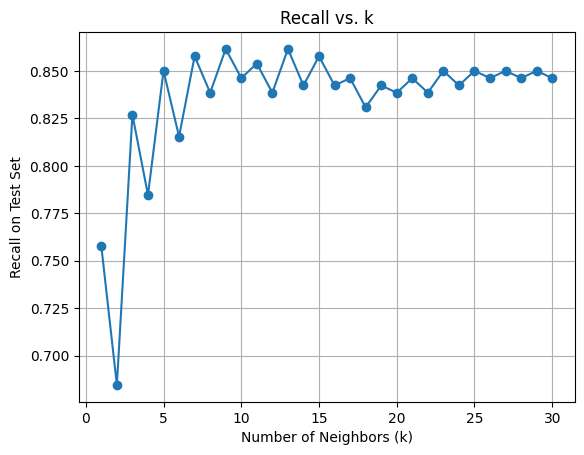

In [78]:
import matplotlib.pyplot as plt

k_values = range(1, 31)
recalls = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(knn_X_train_selected, knn_y_train)
    y_pred = model.predict(knn_X_test_selected)
    recalls.append(recall_score(knn_y_test, y_pred))

plt.plot(k_values, recalls, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Recall on Test Set")
plt.title("Recall vs. k")
plt.grid(True)
plt.show()

In [79]:
# Step 1: Initialize the KNN model (you can tune n_neighbors later)
knn_model = KNeighborsClassifier(n_neighbors=9)
knn_model.fit(knn_X_train_selected, knn_y_train)

# Step 2: Predict on test set
y_pred = knn_model.predict(knn_X_test_selected)
y_prob = knn_model.predict_proba(knn_X_test_selected)[:, 1]

# Step 3: Evaluate the model
accuracy = accuracy_score(knn_y_test, y_pred)
precision = precision_score(knn_y_test, y_pred)
recall = recall_score(knn_y_test, y_pred)
f1 = f1_score(knn_y_test, y_pred)
roc_auc = roc_auc_score(knn_y_test, y_prob)

# Step 4: Print evaluation results
print("KNN Model Evaluation:")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(knn_y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(knn_y_test, y_pred))

KNN Model Evaluation:
Accuracy     : 0.8733
Precision    : 0.7542
Recall       : 0.8615
F1 Score     : 0.8043
ROC AUC Score: 0.9237

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       600
           1       0.75      0.86      0.80       260

    accuracy                           0.87       860
   macro avg       0.85      0.87      0.86       860
weighted avg       0.88      0.87      0.88       860

Confusion Matrix:
[[527  73]
 [ 36 224]]


## SVM

In [80]:
# Step 1: Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto']
}

# Step 2: Define stratified K-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 3: Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=SVC(kernel='rbf', probability=True, random_state=42),
    param_grid=param_grid,
    scoring='recall',  # You can also try 'f1' or 'roc_auc'
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Step 4: Fit the grid search
grid_search.fit(svm_X_train_selected, svm_y_train)

# Step 5: Use best estimator to predict on test set
best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(svm_X_test_selected)
y_prob = best_svm_model.predict_proba(svm_X_test_selected)[:, 1]

# Step 6: Evaluate performance
accuracy = accuracy_score(svm_y_test, y_pred)
precision = precision_score(svm_y_test, y_pred)
recall = recall_score(svm_y_test, y_pred)
f1 = f1_score(svm_y_test, y_pred)
roc_auc = roc_auc_score(svm_y_test, y_prob)

# Step 7: Print results
print("Best Parameters:", grid_search.best_params_)
print("\nSVM Model Evaluation (After Tuning):")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(svm_y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(svm_y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'C': 0.1, 'gamma': 1}

SVM Model Evaluation (After Tuning):
Accuracy     : 0.5581
Precision    : 0.4038
Recall       : 0.9692
F1 Score     : 0.5701
ROC AUC Score: 0.9041

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.38      0.55       600
           1       0.40      0.97      0.57       260

    accuracy                           0.56       860
   macro avg       0.68      0.67      0.56       860
weighted avg       0.80      0.56      0.55       860

Confusion Matrix:
[[228 372]
 [  8 252]]


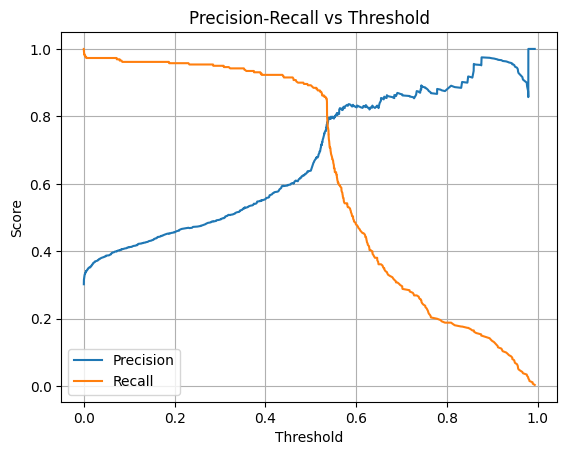

In [81]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision_vals, recall_vals, thresholds = precision_recall_curve(svm_y_test, y_prob)

plt.plot(thresholds, precision_vals[:-1], label="Precision")
plt.plot(thresholds, recall_vals[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

## Random Forest

In [82]:
# Step 1: Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Step 2: Stratified K-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 3: Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Step 4: Fit the model
grid_search.fit(randomforest_X_train_selected, randomforest_y_train)

# Step 5: Evaluate the best model on test set
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(randomforest_X_test_selected)
y_prob = best_rf_model.predict_proba(randomforest_X_test_selected)[:, 1]

# Step 6: Compute metrics
accuracy = accuracy_score(randomforest_y_test, y_pred)
precision = precision_score(randomforest_y_test, y_pred)
recall = recall_score(randomforest_y_test, y_pred)
f1 = f1_score(randomforest_y_test, y_pred)
roc_auc = roc_auc_score(randomforest_y_test, y_prob)

# Step 7: Display results
print("Best Parameters:", grid_search.best_params_)
print("\nRandom Forest Evaluation (After Tuning):")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(randomforest_y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(randomforest_y_test, y_pred))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Random Forest Evaluation (After Tuning):
Accuracy     : 0.9070
Precision    : 0.8543
Recall       : 0.8346
F1 Score     : 0.8444
ROC AUC Score: 0.9346

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       600
           1       0.85      0.83      0.84       260

    accuracy                           0.91       860
   macro avg       0.89      0.89      0.89       860
weighted avg       0.91      0.91      0.91       860

Confusion Matrix:
[[563  37]
 [ 43 217]]


# Part VII. Ensembling

## Voting Classifier

In [85]:
logistic_clf = LogisticRegression(C=0.0001, solver='liblinear', class_weight=None, penalty='l2', random_state=42)
knn_clf = KNeighborsClassifier(n_neighbors=9)
svm_clf = SVC(C=0.1, gamma=1, probability=True, random_state=42)
randomforest_clf  = RandomForestClassifier(n_estimators=100, max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, random_state=42)

### Soft Voting

In [86]:
soft_voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logistic_clf),
        ('knn', knn_clf),
        ('svm', svm_clf),
        ('rf', randomforest_clf)
    ],
    voting='soft'
)

In [89]:
soft_voting_clf.fit(logistic_X_train, logistic_y_train)
y_pred = soft_voting_clf.predict(logistic_X_test)
y_prob = soft_voting_clf.predict_proba(logistic_X_test)[:, 1]  # For soft voting only

print("Voting Classifier Evaluation:")
print(f"Accuracy     : {accuracy_score(logistic_y_test, y_pred):.4f}")
print(f"Precision    : {precision_score(logistic_y_test, y_pred):.4f}")
print(f"Recall       : {recall_score(logistic_y_test, y_pred):.4f}")
print(f"F1 Score     : {f1_score(logistic_y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(logistic_y_test, y_prob):.4f}")  # only if soft voting

Voting Classifier Evaluation:
Accuracy     : 0.8814
Precision    : 0.7801
Recall       : 0.8462
F1 Score     : 0.8118
ROC AUC Score: 0.9307


### Hard Voting

In [102]:
hard_voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logistic_clf),
        ('knn', knn_clf),
        ('svm', svm_clf),
        ('rf', randomforest_clf)
    ],
    voting='hard'
)

In [104]:
hard_voting_clf.fit(logistic_X_train, logistic_y_train)
y_pred = hard_voting_clf.predict(logistic_X_test)

print("Voting Classifier Evaluation:")
print(f"Accuracy     : {accuracy_score(logistic_y_test, y_pred):.4f}")
print(f"Precision    : {precision_score(logistic_y_test, y_pred):.4f}")
print(f"Recall       : {recall_score(logistic_y_test, y_pred):.4f}")
print(f"F1 Score     : {f1_score(logistic_y_test, y_pred):.4f}")

Voting Classifier Evaluation:
Accuracy     : 0.8616
Precision    : 0.7311
Recall       : 0.8577
F1 Score     : 0.7894


## Stacking Model

In [105]:
# Define base models (you can use your tuned models)
base_models = [
    ('lr', LogisticRegression(C=0.0001, solver='liblinear', class_weight=None, penalty='l2', random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=9)),
    ('svm', SVC(C=0.1, gamma=1, probability=True, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, random_state=42))
]

# Define meta-model (blender)
meta_model = LogisticRegression()

# Create StackingClassifier
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,  # 5-fold stacking
    passthrough=False,  # if True, also pass original features to meta-model
    n_jobs=-1
)

# Train
stack_model.fit(logistic_X_train, logistic_y_train)

# Predict
y_pred = stack_model.predict(logistic_X_test)

# Evaluate
print(f"Accuracy     : {accuracy_score(logistic_y_test, y_pred):.4f}")
print(f"Precision    : {precision_score(logistic_y_test, y_pred):.4f}")
print(f"Recall       : {recall_score(logistic_y_test, y_pred):.4f}")
print(f"F1 Score     : {f1_score(logistic_y_test, y_pred):.4f}")

Accuracy     : 0.9000
Precision    : 0.8425
Recall       : 0.8231
F1 Score     : 0.8327
